# Predict Credit Card Fraud

Author:Nutan Mandale

Mentor:Vincent Ramdhanie

### Data Description

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions.
It contains only numerical input variables which are the result of a PCA transformation. Due to cofidentiality issues original features are provided.



In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.metrics import confusion_matrix, make_scorer,accuracy_score,roc_curve,auc,classification_report,precision_recall_curve
from sklearn import tree
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from IPython.display import Image
import pydotplus
import graphviz
import time
%matplotlib inline

In [37]:
#import csv
creditcard_df = pd.read_csv("./creditcard.csv")

In [3]:
creditcard_df.shape

(284807, 31)

In [4]:
creditcard_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [5]:
creditcard_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


After importing the data we find the data is having  284807 row and 31 features.Out of which V1,V2 .. V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'.Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise. We see that there are no null values in the data set.All the features are in float or integers.

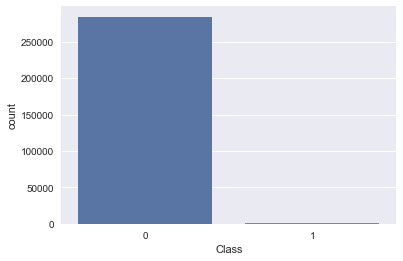

In [6]:
_ = sns.countplot("Class",data=creditcard_df)

In [7]:
Normal_trans = creditcard_df[creditcard_df.Class == 0]
print("Total normal transactions:",len(Normal_trans))
Fraud_trans = creditcard_df[creditcard_df.Class == 1]
print("Total fraud transactions:",len(Fraud_trans))

Total normal transactions: 284315
Total fraud transactions: 492


In [8]:
Percentage_Normal_trans = len(Normal_trans)/len(Normal_trans+Fraud_trans)
print("Normal Transaction in percentage:",Percentage_Normal_trans*100)
Percentage_Fraud_trans= len(Fraud_trans)/len(Normal_trans+Fraud_trans)
print("Fraud Transaction in percentage:",Percentage_Fraud_trans*100)

Normal Transaction in percentage: 99.82725143693798
Fraud Transaction in percentage: 0.1727485630620034


From the plot above we can see that this is very unbalanced data set. We have only 0.172% of the fraudulant data.To ddeal with this type of imbalanced data I am trying following approaches:
    
    1.Ignoring the dataset to be imbalanced and rather than focussing on accuracy of the model evaluate it on specificity and sensitivity.
    2.Oversampling the data set.
    3.Undersampling the dataset.
    4.SMOTE

## Imbalanced data

In this scenario I am taking the imbalanced data as provided and evluate it on the basis of

    1.Use the confusion nmatrix to calculate Precision, Recall
    2.F1score (weighted average of precision recall)
    3.ROC curves - calculates sensitivity/specificity ratio.

In [9]:
# Seperating dependent and independant features
y = creditcard_df['Class']
X = creditcard_df.drop(['Class'], axis = 1)

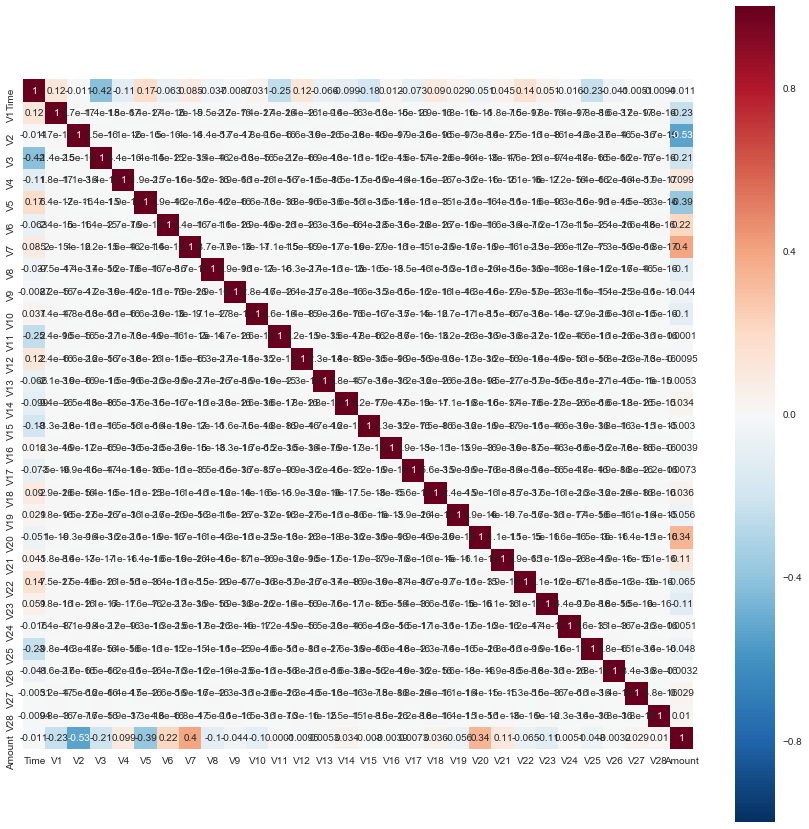

In [10]:
# Let us see if there is any correlation between independent variables
plt.figure(figsize=(15,15))
_ = sns.heatmap(X.corr(),vmax=1, square=True, annot=True);

Let us split the data into training and testing sets.For training purpose I am keeping 75% of data sample and 25% for testing purpose.

In [11]:
# Split the  data
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state=5)


### SVM

In [12]:
# LinearSVC is the classifier

# start a timer
start = time.time()

# Create the classifier model
svm = LinearSVC()

#fit the model
svm.fit(X_train, y_train)

#Stop the timer
end = time.time()

print("Linear SVC", end - start, svm.score(X_test,y_test))
y_test_sv = svm.predict(X_test)
# now evaluate the Single SVC model
y_score = svm.decision_function(X_test)

# Find the average precision score
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, pos_label=1)

print('AUC for Single Linear SVC\n', auc(fpr,tpr))

Linear SVC 76.12593245506287 0.998455099576
Average precision-recall score: 0.13
AUC for Single Linear SVC
 0.692303774962


In [13]:
print('cr:', classification_report(y_test,y_test_sv))
print('Precision for SVM Classifier\n' ,metrics.precision_score(y_test, y_test_sv))
print('Recall for SVM Classifier\n' ,metrics.recall_score(y_test, y_test_sv))

cr:              precision    recall  f1-score   support

          0       1.00      1.00      1.00     71081
          1       0.82      0.12      0.20       121

avg / total       1.00      1.00      1.00     71202

Precision for SVM Classifier
 0.823529411765
Recall for SVM Classifier
 0.115702479339


Confusion Matrix
 [[71078     3]
 [  107    14]]


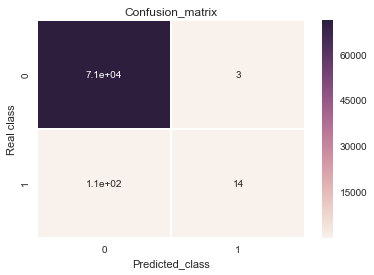

AUC for Single Linear SVC
 0.692303774962


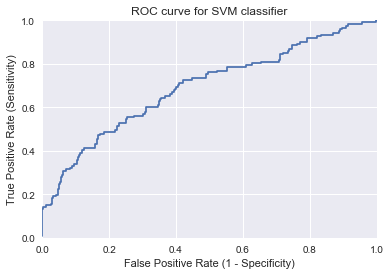

In [14]:
#Confusion Matrix
confusion = confusion_matrix(y_test, y_test_sv)

print('Confusion Matrix\n', confusion)

sns.heatmap(confusion,annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show();

#Area under curve
auc(fpr,tpr)
print('AUC for Single Linear SVC\n', auc(fpr,tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, pos_label=1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for SVM classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)');

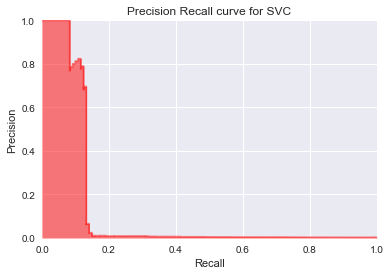

In [15]:
precision, recall, _ = precision_recall_curve(y_test, y_score)


plt.step(recall, precision, color='r', alpha=0.5,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.5, color='r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall curve for SVC');

In [16]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC

n_estimators = 10
start = time.time()
clf = BaggingClassifier(LinearSVC(class_weight='balanced'), max_samples=1.0 / n_estimators, n_estimators=n_estimators)
clf.fit(X_train, y_train)
end = time.time()
print("Bagging SVC", end - start, clf.score(X,y))

# Evaluate the Ensemble model
y_score = clf.decision_function(X_test)
y_test_bag = clf.predict(X_test)
# Find the average precision score
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, pos_label=1)

print('AUC for Ensemble model\n', auc(fpr,tpr))



Bagging SVC 780.1889431476593 0.998409449206
Average precision-recall score: 0.13
AUC for Ensemble model
 0.701703015801


In [17]:
print('cr:', classification_report(y_test,y_test_bag))
print('Precision for Bagging Classifier\n' ,metrics.precision_score(y_test, y_test_bag))
print('Recall for Bagging Classifier\n' ,metrics.recall_score(y_test, y_test_bag))

cr:              precision    recall  f1-score   support

          0       1.00      1.00      1.00     71081
          1       0.80      0.13      0.23       121

avg / total       1.00      1.00      1.00     71202

Precision for Bagging Classifier
 0.8
Recall for Bagging Classifier
 0.132231404959


Confusion Matrix
 [[71077     4]
 [  105    16]]


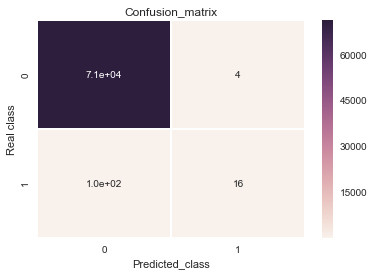

AUC for Bagging 
 0.701703015801


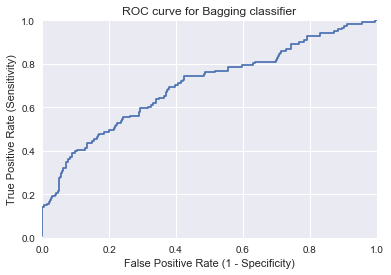

In [18]:
confusion = confusion_matrix(y_test, y_test_bag)

print('Confusion Matrix\n', confusion)

sns.heatmap(confusion,annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show();

#Area under curve
auc(fpr,tpr)
print('AUC for Bagging \n',auc(fpr,tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Bagging classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)');

### Logistic Regression


Accuracy on training set:
0.998735984645

Accuracy on test set:
0.998890480604


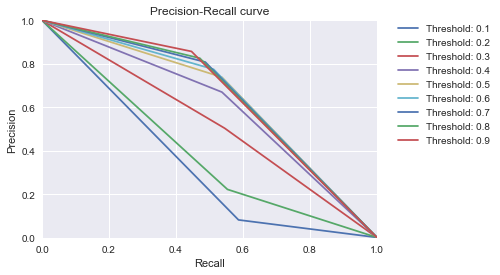

In [125]:
#applying logistic regression
lr = LogisticRegression(penalty='l2', C=0.001)
fit_train = lr.fit(X_train, y_train)

y_test_lr = lr.predict(X_test)
y_score_lr = lr.decision_function(X_test)
#Accuracy score
from sklearn.metrics import accuracy_score
print("\nAccuracy on training set:") 
print(lr.score(X_train, y_train))
print("\nAccuracy on test set:")
print(lr.score(X_test, y_test))

y_pred_o_proba=lr.predict_proba(X_test)[:,1]

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in thresholds:
    y_test_pred_prob = y_pred_o_proba > i
    precision, recall, thresholds= precision_recall_curve(y_test,y_test_pred_prob)
    plt.plot(recall, precision,label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title('Precision-Recall curve')    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)



cr:              precision    recall  f1-score   support

          0       1.00      1.00      1.00     71081
          1       0.74      0.54      0.62       121

avg / total       1.00      1.00      1.00     71202

Precision for Logistic Regression Classifier
 0.738636363636
Recall for logistic Regression Classifier
 0.537190082645
Confusion Matrix
 [[71058    23]
 [   56    65]]


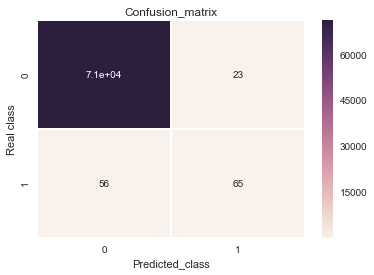

AUC for Logistic regression
 0.882026918191


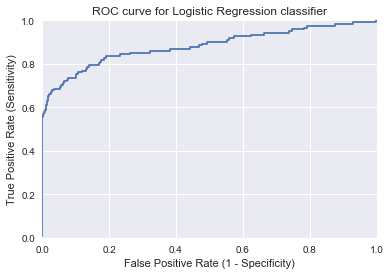

In [126]:
print('cr:', classification_report(y_test,y_test_lr))
print('Precision for Logistic Regression Classifier\n' ,metrics.precision_score(y_test, y_test_lr))
print('Recall for logistic Regression Classifier\n' ,metrics.recall_score(y_test, y_test_lr))

#Confusion Matrix
confusion = confusion_matrix(y_test, y_test_lr)

print('Confusion Matrix\n', confusion)

sns.heatmap(confusion,annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

#Area under curve
auc(fpr,tpr)
print('AUC for Logistic regression\n',auc(fpr,tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score_lr)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Logistic Regression classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)');


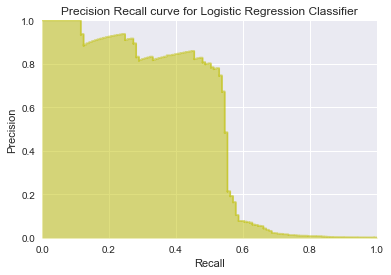

In [127]:

precision, recall, _ = precision_recall_curve(y_test, y_score_lr)


plt.step(recall, precision, color='y', alpha=0.5,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.5, color='y')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall curve for Logistic Regression Classifier');

Though the accuracy in this model looks very good but if we take a look at confusion matrix we can see TN to be very high than all the other values. 

### Decision Tree

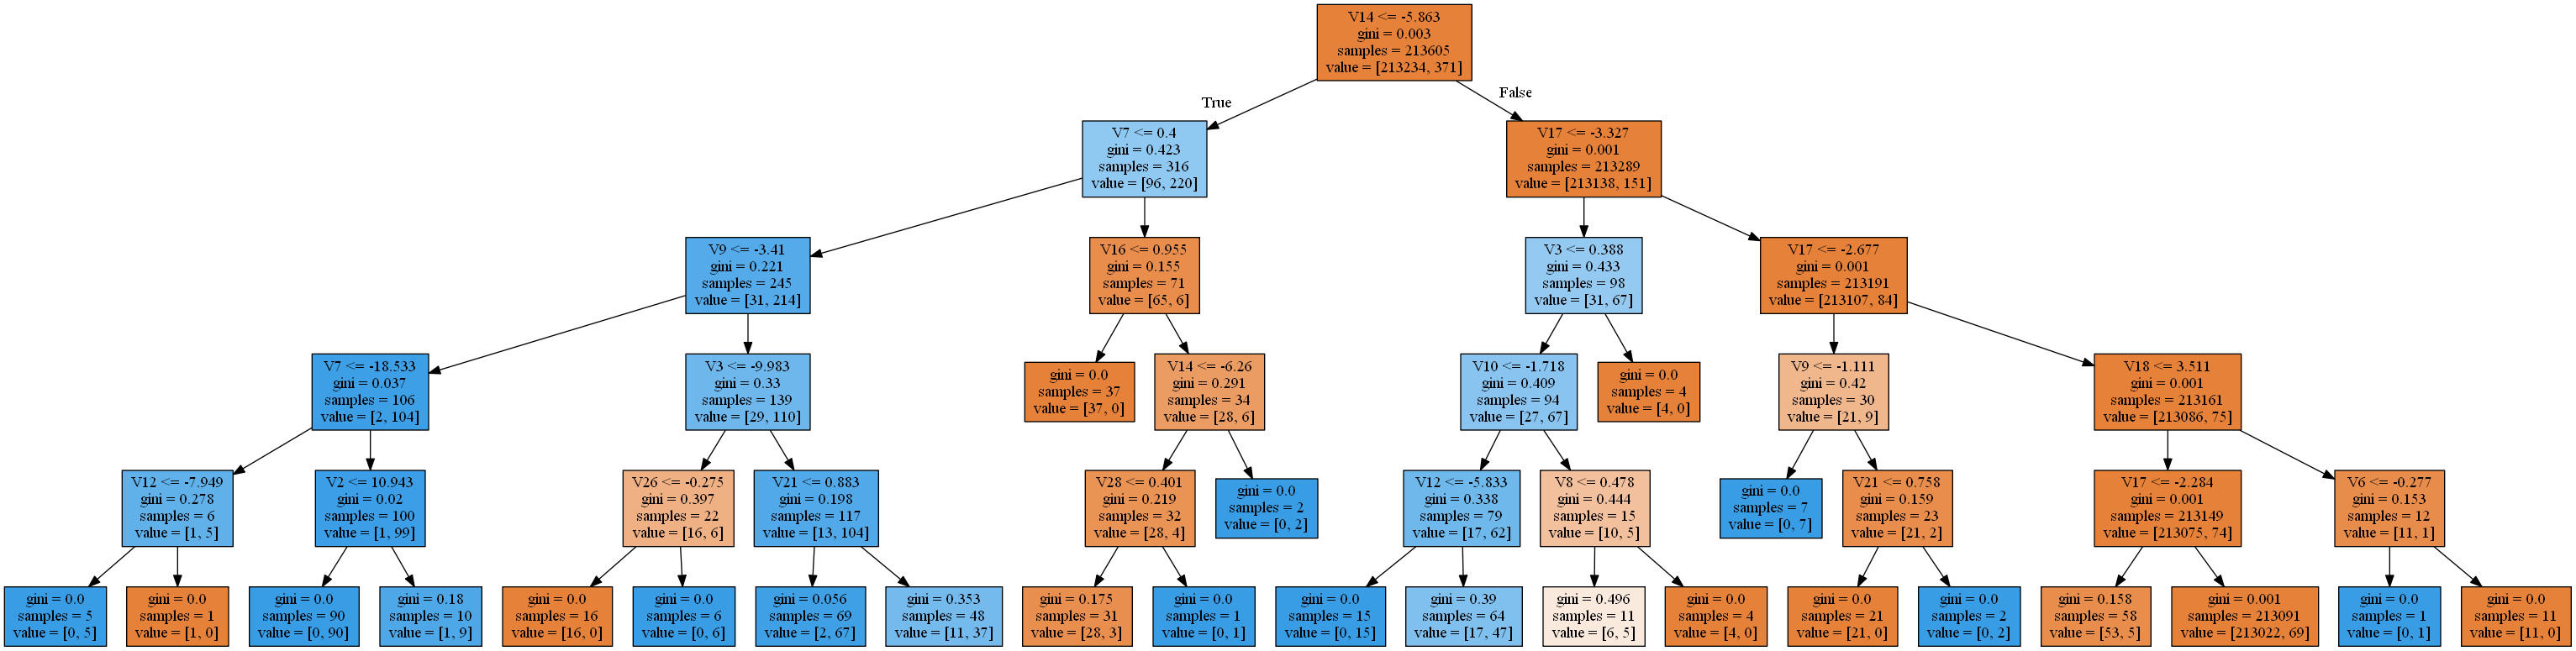

In [25]:
# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    max_features=3,
    max_depth=5,
    random_state = 1000
)

decision_tree.fit(X_train, y_train)
y_1_predictions = decision_tree.predict(X_test)
y_prob = decision_tree.predict_proba(X_test)
# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [26]:
print("\nAccuracy on training set: {:.3f}".format(decision_tree.score(X_train, y_train)))
print("\nAccuracy on test set: {:.3f}".format(decision_tree.score(X_test, y_test)))


Accuracy on training set: 0.999

Accuracy on test set: 0.999


In [27]:
print(len(y_prob))
print(len(y_test))

71202
71202


Confusion Matrix
 [[71067    14]
 [   28    93]]


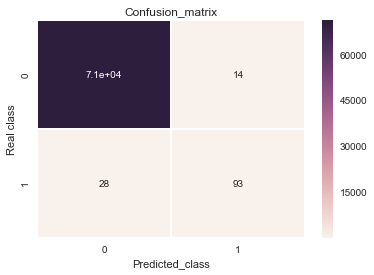

AUC for Decision tree classifier
 0.882026918191


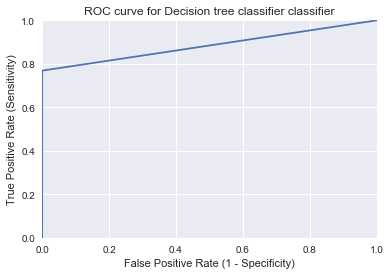

In [28]:
#confusion matrix
confusion = confusion_matrix(y_test, y_1_predictions)
print('Confusion Matrix\n', confusion)

sns.heatmap(confusion,annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

print('AUC for Decision tree classifier\n',auc(fpr,tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_1_predictions)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Decision tree classifier classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)');

Precision for Decision Tree Classifier
 0.869158878505
Recall for Decision Tree Classifier
 0.768595041322


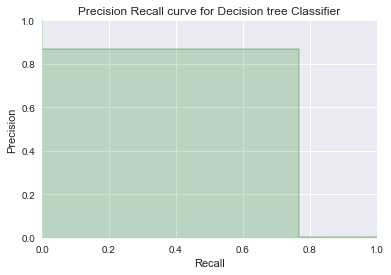

In [29]:
print('Precision for Decision Tree Classifier\n' ,metrics.precision_score(y_test, y_1_predictions))
print('Recall for Decision Tree Classifier\n' ,metrics.recall_score(y_test, y_1_predictions))
precision, recall, _ = precision_recall_curve(y_test, y_1_predictions)

plt.step(recall, precision, color='g', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='g')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall curve for Decision tree Classifier');

In [30]:
print('cr:', classification_report(y_test,y_1_predictions))
print('Precision for Decision Tree Classifier\n' ,metrics.precision_score(y_test, y_1_predictions))
print('Recall for Decision Tree Classifier\n' ,metrics.recall_score(y_test, y_1_predictions))

cr:              precision    recall  f1-score   support

          0       1.00      1.00      1.00     71081
          1       0.87      0.77      0.82       121

avg / total       1.00      1.00      1.00     71202

Precision for Decision Tree Classifier
 0.869158878505
Recall for Decision Tree Classifier
 0.768595041322


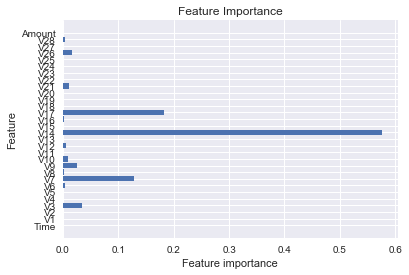

In [32]:
n_features = X.shape[1]
plt.figure()
plt.barh(range(n_features), decision_tree.feature_importances_, align='center')
plt.yticks(np.arange(n_features), X.columns)
plt.xlabel("Feature importance")
plt.ylabel("Feature")
plt.title("Feature Importance");

### Random Forest

In [40]:
#Applying Random forest classifier
from sklearn import ensemble
rfc = ensemble.RandomForestClassifier(
    n_estimators=15,
    max_features=3,
    max_depth=5
)

rfc.fit(X_train, y_train)
y_predict = rfc.predict(X_test)

print("\nAccuracy on training set: {:.3f}".format(rfc.score(X_train, y_train)))
print("\nAccuracy on test set: {:.3f}".format(rfc.score(X_test, y_test)))


Accuracy on training set: 0.999

Accuracy on test set: 0.999


Confusion Matrix
 [[71075     6]
 [   42    79]]
AUC for Random Forest  classifier
 0.884199041461


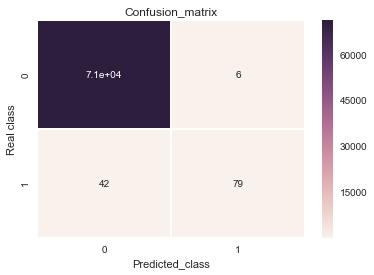

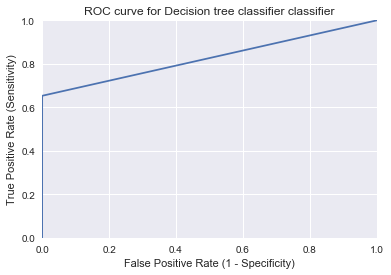

In [41]:
#confusion matrix
confusion = confusion_matrix(y_test, y_predict)
print('Confusion Matrix\n', confusion)#Area under curve
auc(fpr,tpr)
print('AUC for Random Forest  classifier\n',auc(fpr,tpr))

sns.heatmap(confusion,annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Decision tree classifier classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)');

Our decision tree classifier and random forest classifier also gave us very good accuracy but if we evaluate our classifiers on confusion matrix and AUC we find that they dont perform well.

cr:              precision    recall  f1-score   support

          0       1.00      1.00      1.00     71081
          1       0.93      0.65      0.77       121

avg / total       1.00      1.00      1.00     71202

Precision for Decision Tree Classifier
 0.929411764706
Recall for Decision Tree Classifier
 0.652892561983


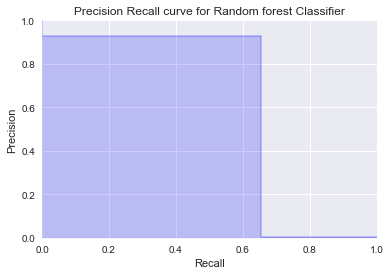

In [42]:
print('cr:', classification_report(y_test,y_predict))
print('Precision for Decision Tree Classifier\n' ,metrics.precision_score(y_test, y_predict))
print('Recall for Decision Tree Classifier\n' ,metrics.recall_score(y_test, y_predict))

precision, recall, _ = precision_recall_curve(y_test, y_predict)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall curve for Random forest Classifier');

Let us sum up results we got till now

In [168]:
#summing up results of all the models and forming a dataframe
results1 = [{'Model':'SVM','F1 Score': 0.05,'AUC':0.644,'Precision':1.00,'Recall':0.024},
            {'Model':'Bagging','F1 Score': 0.23,'AUC':0.711,'Precision':0.8,'Recall':0.132},
            {'Model':'Logistic Regression','F1 Score': 0.711,'AUC':0.62,'Precision':0.738,'Recall':0.537},
            {'Model':'Decision Tree Classifier','F1 Score': 0.882,'AUC':0.82,'Precision':0.869,'Recall':0.768},
            {'Model':'Random Forest Classifier','F1 Score': 0.876,'AUC':0.83,'Precision':0.928,'Recall':0.752},
            ]
results1_df = pd.DataFrame(results1)

results1_df.head()

,AUC,F1 Score,Model,Precision,Recall
0,0.644,0.050,SVM,1.000,0.024
1,0.711,0.230,Bagging,0.800,0.132
2,0.620,0.711,Logistic Regression,0.738,0.537
3,0.820,0.882,Decision Tree Classifier,0.869,0.768
4,0.830,0.876,Random Forest Classifier,0.928,0.752


### Oversample Method
    

In [46]:
# Isolate all positive rows
pos_df = creditcard_df.loc[creditcard_df['Class'] == 1]

# Duplicating the positive rows
oversampled = pd.concat([creditcard_df, pos_df, pos_df])
oversampled.shape

(285791, 31)

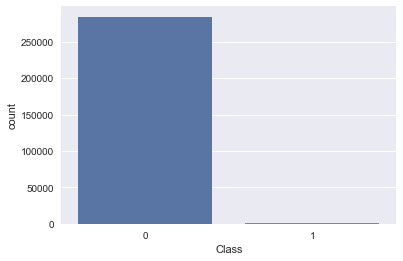

In [47]:
_ = sns.countplot("Class",data = oversampled)

In [48]:
y = oversampled['Class']
X = oversampled.drop(['Class'], axis = 1)
print("Dependant variable shape:", y.shape)
print("Independant variable shape:", X.shape)

Dependant variable shape: (285791,)
Independant variable shape: (285791, 30)


In [49]:
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X, y,test_size=0.25,random_state=5)

### SVM for oversampled data

In [133]:
# start a timer
start = time.time()

# Create the classifier model
svm = LinearSVC()

#fit the model
svm.fit(X_train_o, y_train_o)

#Stop the timer
end = time.time()

print("Linear SVC", end - start, svm.score(X_test,y_test))
y_test_svo = svm.predict(X_test)
# now evaluate the Single SVC model
y_score_o = svm.decision_function(X_test)

# Find the average precision score
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score_o)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score_o, pos_label=1)

print('AUC for Single Linear SVC\n', auc(fpr,tpr))

Linear SVC 99.5175530910492 0.998609589618
Average precision-recall score: 0.31
AUC for Single Linear SVC
 0.790752977542


In [135]:
print('cr:', classification_report(y_test,y_test_svo))
print('Precision for SVM Classifier\n' ,metrics.precision_score(y_test, y_test_svo))
print('Recall for SVM Classifier\n' ,metrics.recall_score(y_test, y_test_svo))

cr:              precision    recall  f1-score   support

          0       1.00      1.00      1.00     71081
          1       0.69      0.33      0.45       121

avg / total       1.00      1.00      1.00     71202

Precision for SVM Classifier
 0.689655172414
Recall for SVM Classifier
 0.330578512397


Confusion Matrix
 [[71063    18]
 [   81    40]]


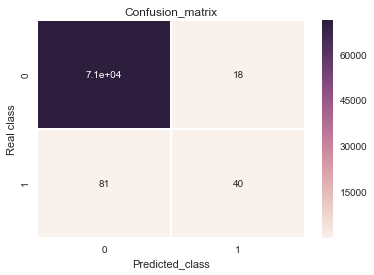

AUC for Single Linear SVC
 0.790752977542


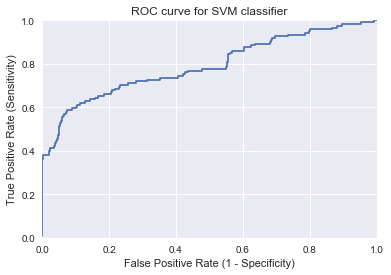

In [137]:
#Confusion Matrix
confusion = confusion_matrix(y_test, y_test_svo)

print('Confusion Matrix\n', confusion)

sns.heatmap(confusion,annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show();

#Area under curve
auc(fpr,tpr)
print('AUC for Single Linear SVC\n', auc(fpr,tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score_o, pos_label=1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for SVM classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)');

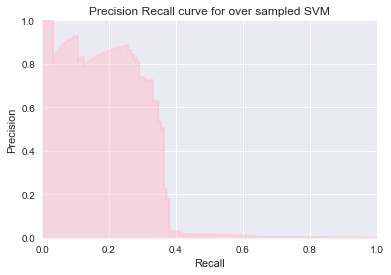

In [138]:
precision, recall, _ = precision_recall_curve(y_test, y_score_o)


plt.step(recall, precision, color='pink', alpha=0.5,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.5, color='pink')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall curve for over sampled SVM');

### Bagging for oversampled Data

In [54]:
n_estimators = 10
start = time.time()
clf = BaggingClassifier(LinearSVC(class_weight='balanced'), max_samples=1.0 / n_estimators, n_estimators=n_estimators)
clf.fit(X_train_o, y_train_o)
end = time.time()
print("Bagging SVC", end - start, clf.score(X,y))

# Evaluate the Ensemble model
y_score_ob = clf.decision_function(X_test)
y_test_obag = clf.predict(X_test)
# Find the average precision score
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score_ob)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score_ob, pos_label=1)

print('AUC for Ensemble model\n', auc(fpr,tpr))

Bagging SVC 1160.9630250930786 0.995755639611
Average precision-recall score: 0.21
AUC for Ensemble model
 0.709445770653


cr:              precision    recall  f1-score   support

          0       1.00      1.00      1.00     71078
          1       0.96      0.20      0.33       370

avg / total       1.00      1.00      0.99     71448

Precision for oversampled Bagging Classifier
 0.961038961039
Recall for oversampled Bagging Classifier
 0.2
Confusion Matrix
 [[71075     3]
 [  296    74]]


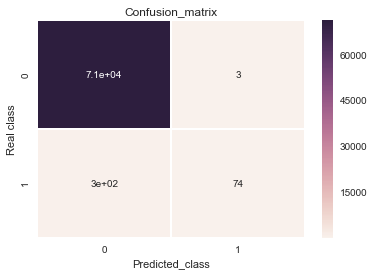

AUC for Bagging 
 0.709445770653


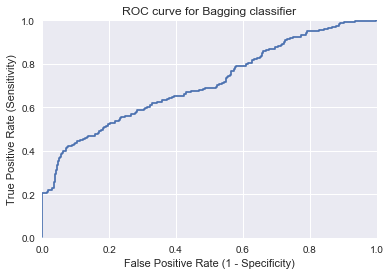

In [55]:
confusion = confusion_matrix(y_test_o, y_test_obag)
print('cr:', classification_report(y_test_o,y_test_obag))
print('Precision for oversampled Bagging Classifier\n' ,metrics.precision_score(y_test_o,y_test_obag))
print('Recall for oversampled Bagging Classifier\n' ,metrics.recall_score(y_test_o,y_test_obag))
print('Confusion Matrix\n', confusion)

sns.heatmap(confusion,annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show();

#Area under curve
auc(fpr,tpr)
print('AUC for Bagging \n',auc(fpr,tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test_o, y_score_ob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Bagging classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)');

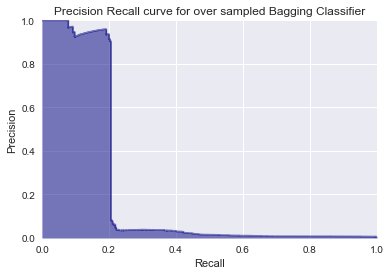

In [56]:
precision, recall, _ = precision_recall_curve(y_test_o, y_score_ob)


plt.step(recall, precision, color='navy', alpha=0.5,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.5, color='navy')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall curve for over sampled Bagging Classifier');

### Logistic Regression for oversampled data

In [57]:
#applying logistic regression
lr = LogisticRegression(penalty='l2', C=0.001)
fit_train_o = lr.fit(X_train_o, y_train_o)

y_test_lr_o = lr.predict(X_test_o)
y_score_olr = lr.decision_function(X_test_o)
#Accuracy score
from sklearn.metrics import accuracy_score
print("\nAccuracy on training set:") 
print(lr.score(X_train_o, y_train_o))
print("\nAccuracy on test set:")
print(lr.score(X_test_o, y_test_o))


Accuracy on training set:
0.997877234153

Accuracy on test set:
0.997844586273


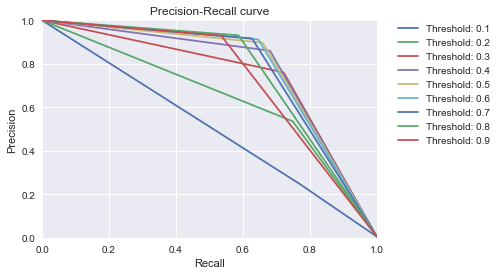

In [58]:
y_pred_o_proba1 = lr.predict_proba(X_test_o)[:,1]

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in thresholds:
    y_test_pred_prob = y_pred_o_proba1 > i
    precision, recall, thresholds= precision_recall_curve(y_test_o,y_test_pred_prob)
    plt.plot(recall, precision,label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title('Precision-Recall curve')    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

Confusion Matrix
 [[71050    28]
 [  126   244]]


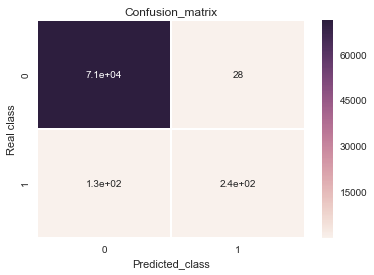

cr:              precision    recall  f1-score   support

          0       1.00      1.00      1.00     71078
          1       0.90      0.66      0.76       370

avg / total       1.00      1.00      1.00     71448

AUC for Logistic regression
 0.709445770653


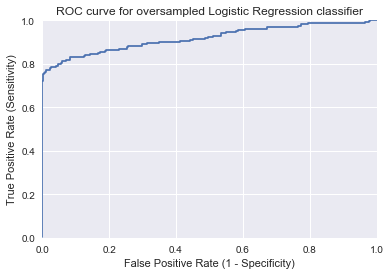

In [59]:
#Confusion Matrix
confusion = confusion_matrix(y_test_o, y_test_lr_o)

print('Confusion Matrix\n', confusion)

sns.heatmap(confusion,annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show();


print('cr:', classification_report(y_test_o, y_test_lr_o))

#Area under curve
auc(fpr,tpr)
print('AUC for Logistic regression\n',auc(fpr,tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test_o, y_score_olr)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for oversampled Logistic Regression classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)');

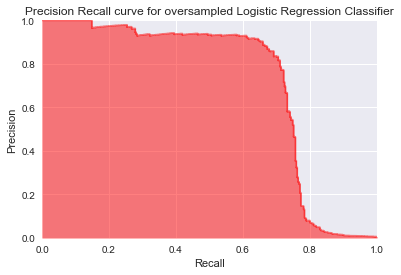

In [60]:
precision, recall, _ = precision_recall_curve(y_test_o, y_score_olr)


plt.step(recall, precision, color='r', alpha=0.5,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.5, color='r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall curve for oversampled Logistic Regression Classifier');

### Decision tree Classifier

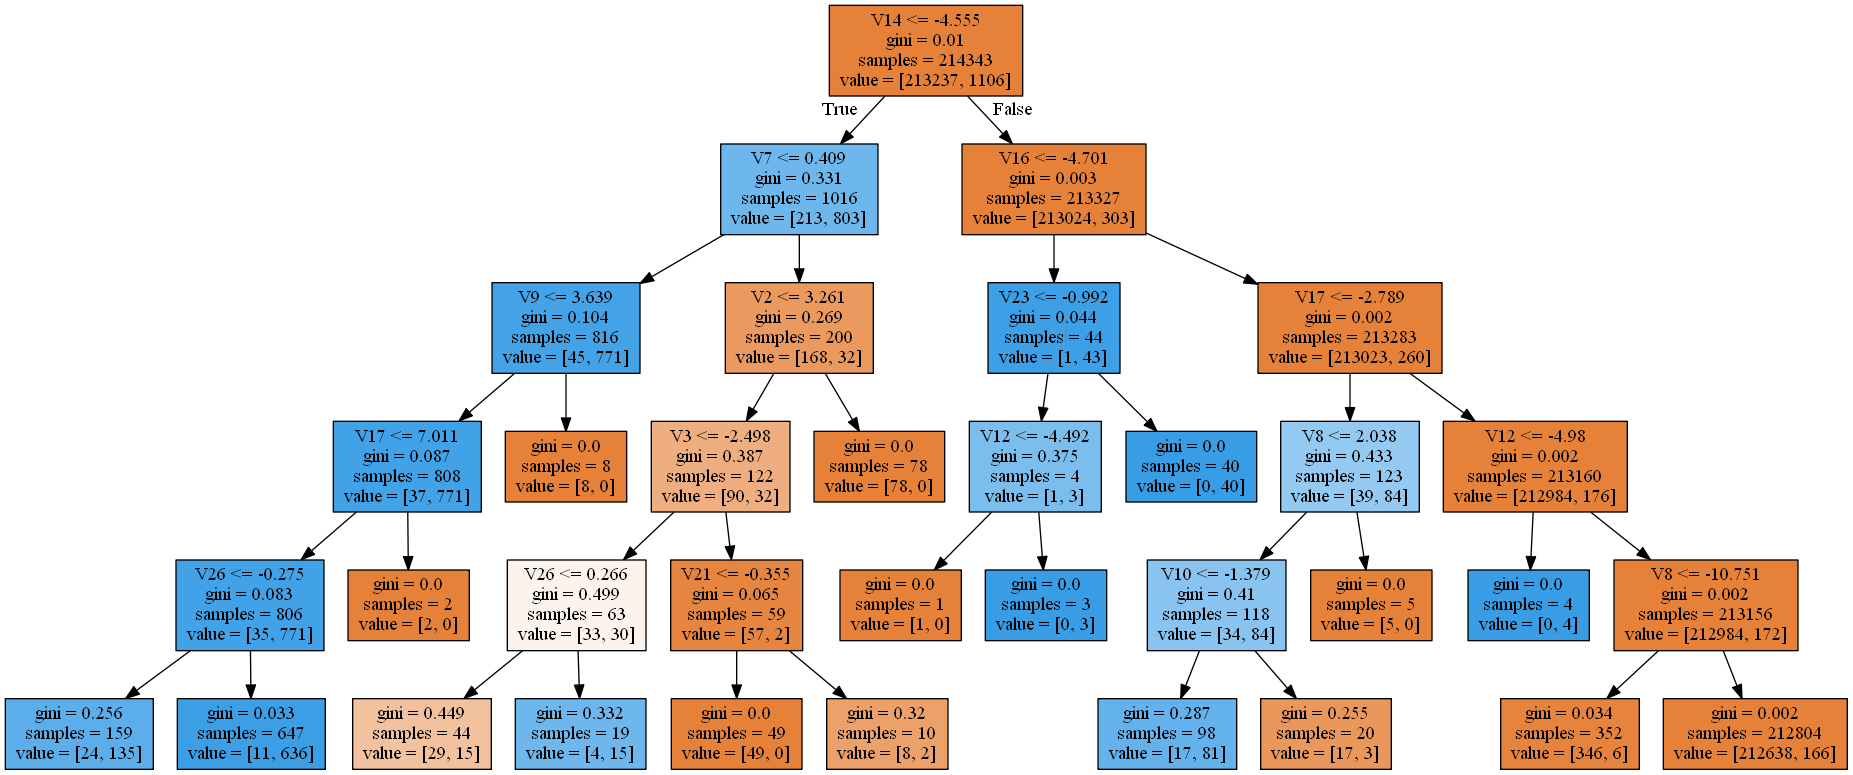

In [61]:
# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    max_features=3,
    max_depth=5,
    random_state = 1000
)

decision_tree.fit(X_train_o, y_train_o)
y_1_predictions_o = decision_tree.predict(X_test)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [62]:
print("\nAccuracy on training set: {:.3f}".format(decision_tree.score(X_train_o, y_train_o)))
print("\nAccuracy on test set: {:.3f}".format(decision_tree.score(X_test, y_test)))


Accuracy on training set: 0.999

Accuracy on test set: 0.999


Confusion Matrix
 [[71057    21]
 [   78   292]]


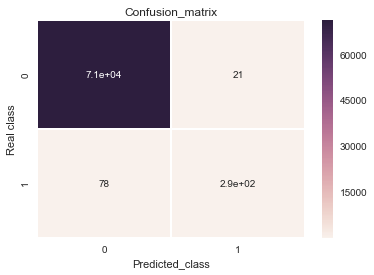

AUC for Decision tree classifier
 0.936335348301


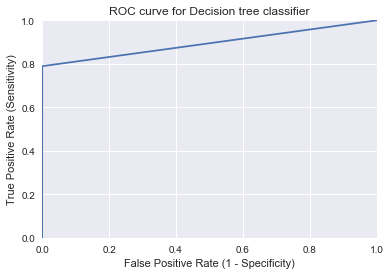

In [146]:
#confusion matrix
confusion = confusion_matrix(y_test_o, y_1_predictions_o)
print('Confusion Matrix\n', confusion)

sns.heatmap(confusion,annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

print('AUC for Decision tree classifier\n',auc(fpr,tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test_o, y_1_predictions_o)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Decision tree classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)');

cr:              precision    recall  f1-score   support

          0       1.00      1.00      1.00     71078
          1       0.93      0.79      0.86       370

avg / total       1.00      1.00      1.00     71448

Precision for Decision Tree Classifier
 0.932907348243
Recall for Decision Tree Classifier
 0.789189189189


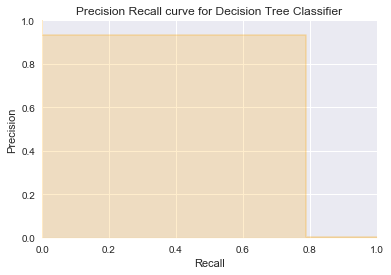

In [64]:
print('cr:', classification_report(y_test_o, y_1_predictions_o))
print('Precision for Decision Tree Classifier\n' ,metrics.precision_score(y_test_o, y_1_predictions_o))
print('Recall for Decision Tree Classifier\n' ,metrics.recall_score(y_test_o, y_1_predictions_o))
precision, recall, _ = precision_recall_curve(y_test_o, y_1_predictions_o)

plt.step(recall, precision, color='orange', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall curve for Decision Tree Classifier');

### Randomforest Classifier

In [65]:
#Applying Random forest classifier
rfc = ensemble.RandomForestClassifier(
    n_estimators=15,
    max_features=3,
    max_depth=5
)

rfc.fit(X_train_o, y_train_o)
y_predict_o = rfc.predict(X_test_o)

print("\nAccuracy on training set: {:.3f}".format(rfc.score(X_train_o, y_train_o)))
print("\nAccuracy on test set: {:.3f}".format(rfc.score(X_test_o, y_test_o)))


Accuracy on training set: 0.999

Accuracy on test set: 0.999


Confusion Matrix
 [[71066    12]
 [   88   282]]
AUC for Random Forest  classifier
 0.89444686956


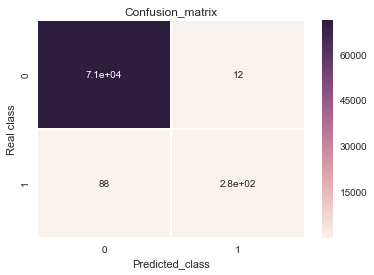

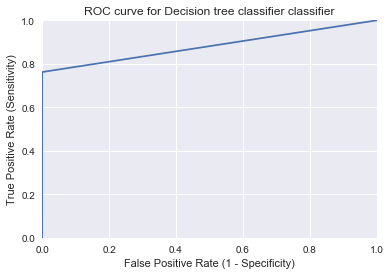

In [66]:
#confusion matrix
confusion = confusion_matrix(y_test_o, y_predict_o)
print('Confusion Matrix\n', confusion)

#Area under curve
auc(fpr,tpr)
print('AUC for Random Forest  classifier\n',auc(fpr,tpr))

sns.heatmap(confusion,annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

fpr, tpr, thresholds = metrics.roc_curve(y_test_o, y_predict_o)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Decision tree classifier classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)');

cr:              precision    recall  f1-score   support

          0       1.00      1.00      1.00     71078
          1       0.96      0.76      0.85       370

avg / total       1.00      1.00      1.00     71448

Precision for oversampled Random Classifier
 0.959183673469
Recall for oversampled Random Classifier
 0.762162162162


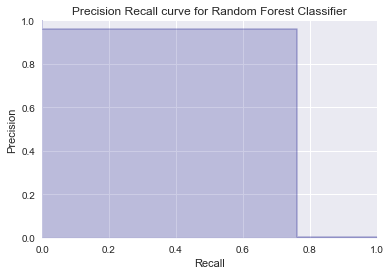

In [67]:
print('cr:', classification_report(y_test_o, y_predict_o))
print('Precision for oversampled Random Classifier\n' ,metrics.precision_score(y_test_o,y_predict_o))
print('Recall for oversampled Random Classifier\n' ,metrics.recall_score(y_test_o,y_predict_o))

precision, recall, _ = precision_recall_curve(y_test_o, y_predict_o)

plt.step(recall, precision, color='navy', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='navy')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall curve for Random Forest Classifier');

Let us sum up the results of the oversampled dataset

In [71]:
#Undersampling the ceditcard dataset
count_fraud = len(Fraud_trans)
fraud_ind = creditcard_df[creditcard_df.Class == 1].index
norm_ind = creditcard_df[creditcard_df.Class == 0].index

r_normal_ind = np.random.choice(norm_ind, count_fraud, replace = False) # random 

undersample_indices = np.concatenate([fraud_ind,r_normal_ind])
undersample_df = creditcard_df.iloc[undersample_indices,:]

### Undersampling Data

In [72]:
undersample_df.shape

(984, 31)

In [73]:
undersample_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


In [74]:
fraud = undersample_df[undersample_df.Class == 1]
print("Total fraudulant transaction in undersampled dataset are",len(fraud))

norm = undersample_df[undersample_df.Class == 0]
print("Total normal transaction in undersampled dataset are",len(norm))

Total fraudulant transaction in undersampled dataset are 492
Total normal transaction in undersampled dataset are 492


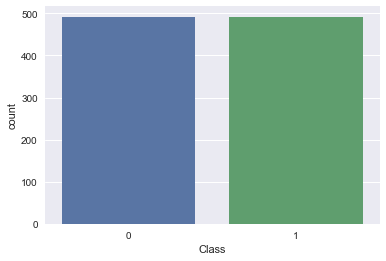

In [75]:
_ = sns.countplot("Class",data = undersample_df)

Here we are getting balanced dataset.We will train our model on this data.

In [76]:
y_u = undersample_df['Class']
X_u = undersample_df.drop(['Class'], axis = 1)

In [77]:
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_u, y_u,test_size=0.25,random_state=5)

### SVM for undersampled data

In [78]:
# start a timer
start = time.time()

# Create the classifier model
svm = LinearSVC()

#fit the model
svm.fit(X_train_u, y_train_u)

#Stop the timer
end = time.time()

print("Linear SVC", end - start, svm.score(X_test_u,y_test_u))
y_test_svu = svm.predict(X_test_u)
y_test_svu1 = svm.predict(X_test)

# now evaluate the Single SVC model
y_score_u = svm.decision_function(X_test_u)
y_score_u1 = svm.decision_function(X_test)
# Find the average precision score
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test_u, y_score_u)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

fpr, tpr, thresholds = metrics.roc_curve(y_test_u, y_score_u, pos_label=1)

print('AUC for Single Linear SVC\n', auc(fpr,tpr))

Linear SVC 0.30921459197998047 0.780487804878
Average precision-recall score: 0.88
AUC for Single Linear SVC
 0.865848806366


In [79]:
print('cr:', classification_report(y_test_u,y_test_svu))
print('Precision for undersampled SVM Classifier\n' ,metrics.precision_score(y_test_u,y_test_svu))
print('Recall for undersampled SVM Classifier\n' ,metrics.recall_score(y_test_u,y_test_svu))

cr:              precision    recall  f1-score   support

          0       0.72      0.96      0.82       130
          1       0.93      0.58      0.71       116

avg / total       0.82      0.78      0.77       246

Precision for undersampled SVM Classifier
 0.930555555556
Recall for undersampled SVM Classifier
 0.577586206897


Confusion Matrix
 [[125   5]
 [ 49  67]]


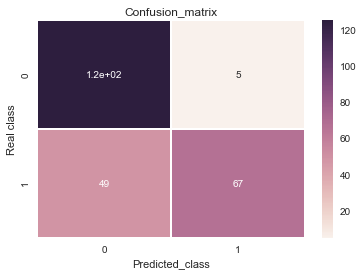

AUC for Single Linear SVC
 0.865848806366


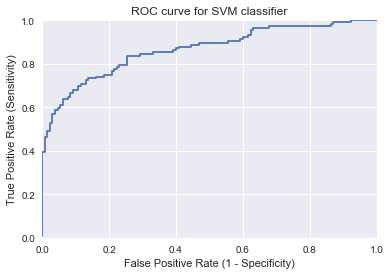

In [80]:
#Confusion Matrix
confusion = confusion_matrix(y_test_u, y_test_svu)

print('Confusion Matrix\n', confusion)

sns.heatmap(confusion,annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show();

#Area under curve
auc(fpr,tpr)
print('AUC for Single Linear SVC\n', auc(fpr,tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test_u, y_score_u, pos_label=1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for SVM classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)');

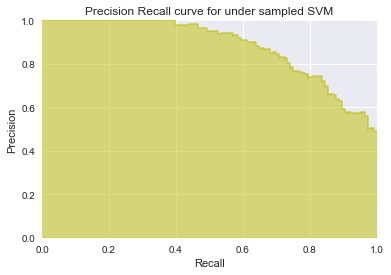

In [81]:
precision, recall, _ = precision_recall_curve(y_test_u, y_score_u)

plt.step(recall, precision, color='y', alpha=0.5,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.5, color='y')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall curve for under sampled SVM');

Testing on creditcard dataset

Confusion Matrix
 [[68939  2142]
 [   40    81]]
AUC for Logistic Regression classifier
 0.865848806366


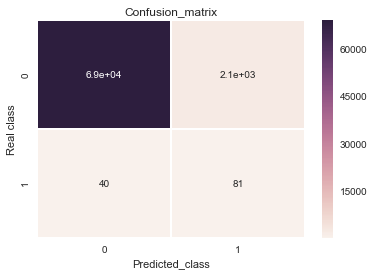

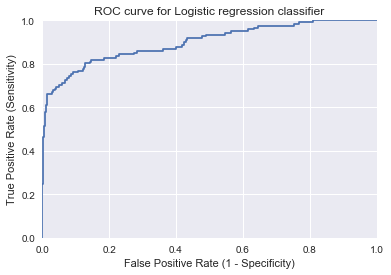

In [82]:
#confusion matrix
confusion = confusion_matrix(y_test, y_test_svu1)
print('Confusion Matrix\n', confusion)

#Area under curve
auc(fpr,tpr)
print('AUC for Logistic Regression classifier\n',auc(fpr,tpr))

sns.heatmap(confusion,annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score_u1, pos_label=1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Logistic regression classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)');


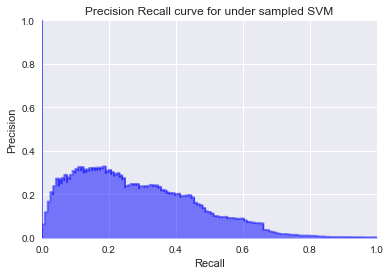

In [172]:
precision, recall, _ = precision_recall_curve(y_test, y_score_u1)


plt.step(recall, precision, color='b', alpha=0.5,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.5, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall curve for under sampled SVM');

In [174]:
print('cr:', classification_report(y_test, y_test_svu1))
print('Precision for undersampled SVM Classifier\n' ,metrics.precision_score(y_test, y_test_svu1))
print('Recall for undersampled SVM Classifier\n' ,metrics.recall_score(y_test, y_test_svu1))

cr:              precision    recall  f1-score   support

          0       1.00      0.97      0.98     71081
          1       0.04      0.67      0.07       121

avg / total       1.00      0.97      0.98     71202

Precision for undersampled SVM Classifier
 0.0364372469636
Recall for undersampled SVM Classifier
 0.669421487603


We can see overfitting in this case

### Bagging for undersampled data

In [175]:
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import LinearSVC

n_estimators = 10
start = time.time()
clf = BaggingClassifier(LinearSVC(class_weight='balanced'), max_samples=1.0 / n_estimators, n_estimators=n_estimators)
clf.fit(X_train_u, y_train_u)
end = time.time()
print("Bagging SVC", end - start, clf.score(X,y))

# Evaluate the Ensemble model
y_score = clf.decision_function(X_test)
y_test_bag = clf.predict(X_test)
# Find the average precision score
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, pos_label=1)

print('AUC for Ensemble model\n', auc(fpr,tpr))


Bagging SVC 2.062420129776001 0.974435319357
Average precision-recall score: 0.11
AUC for Ensemble model
 0.890097445575


In [176]:
print('cr:', classification_report(y_test,y_test_bag))
print('Precision for Bagging Classifier\n' ,metrics.precision_score(y_test, y_test_bag))
print('Recall for Bagging Classifier\n' ,metrics.recall_score(y_test, y_test_bag))

cr:              precision    recall  f1-score   support

          0       1.00      0.98      0.99     71081
          1       0.04      0.53      0.07       121

avg / total       1.00      0.98      0.99     71202

Precision for Bagging Classifier
 0.036036036036
Recall for Bagging Classifier
 0.528925619835


Confusion Matrix
 [[69369  1712]
 [   57    64]]


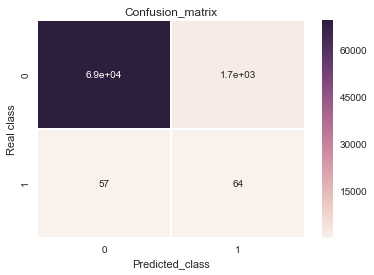

AUC for Bagging 
 0.890097445575


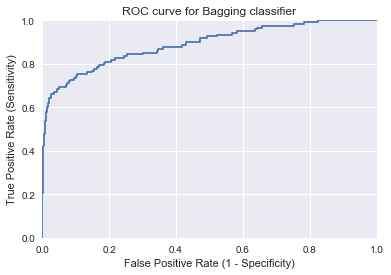

In [177]:
confusion = confusion_matrix(y_test, y_test_bag)

print('Confusion Matrix\n', confusion)

sns.heatmap(confusion,annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show();

#Area under curve
auc(fpr,tpr)
print('AUC for Bagging \n',auc(fpr,tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Bagging classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)');

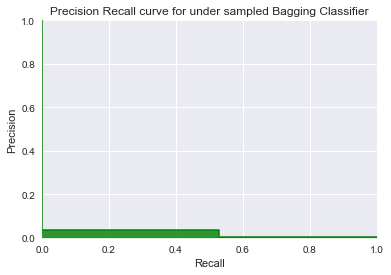

In [178]:
precision, recall, _ = precision_recall_curve(y_test,y_test_bag)


plt.step(recall, precision, color='g', alpha=0.8,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.8, color='g')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall curve for under sampled Bagging Classifier');

### Logistic Regression Classification

In [87]:
#applying logistic regression
lr = LogisticRegression(penalty='l2', C=0.001)
fit_train_u = lr.fit(X_train_u, y_train_u)

y_test_lr_u = lr.predict(X_test_u)

#Accuracy score
from sklearn.metrics import accuracy_score
print("\nAccuracy on training set:") 
print(lr.score(X_train_u, y_train_u))
print("\nAccuracy on test set:")
print(lr.score(X_test_u, y_test_u))


Accuracy on training set:
0.924119241192

Accuracy on test set:
0.918699186992


In [88]:
y_test_lr_1 = lr.predict(X_test)

In [89]:
y_pred_u_proba=lr.predict_proba(X_test_u)[:,1]

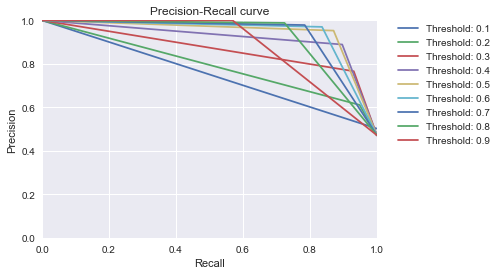

In [90]:
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in thresholds:
    y_test_pred_prob = y_pred_u_proba > i
    precision, recall, thresholds= precision_recall_curve(y_test_u,y_test_pred_prob)
    plt.plot(recall, precision,label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title('Precision-Recall curve')    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

Confusion Matrix
 [[125   5]
 [ 15 101]]
AUC for Logistic Regression classifier
 0.670637304595


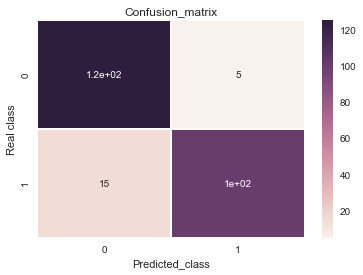

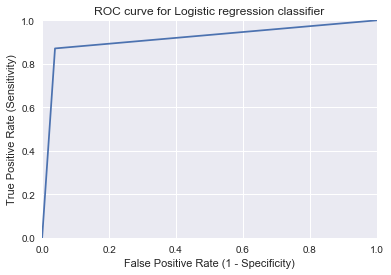

In [91]:
#confusion matrix
confusion = confusion_matrix(y_test_u, y_test_lr_u)
print('Confusion Matrix\n', confusion)

#Area under curve
auc(fpr,tpr)
print('AUC for Logistic Regression classifier\n',auc(fpr,tpr))

sns.heatmap(confusion,annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

fpr, tpr, thresholds = metrics.roc_curve(y_test_u, y_test_lr_u)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Logistic regression classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)');


Testing on the creditcard data set

Confusion Matrix
 [[68887  2194]
 [   16   105]]
AUC for Logistic Regression classifier
 0.916114058355


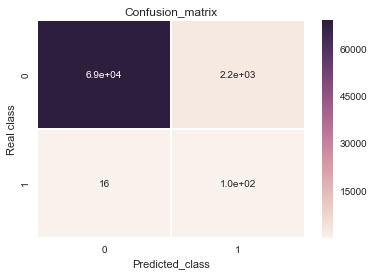

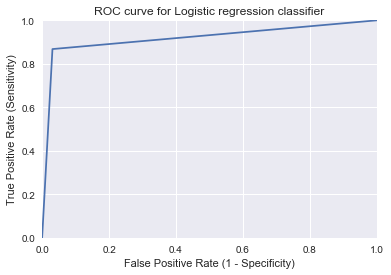

In [92]:
#confusion matrix
confusion = confusion_matrix(y_test, y_test_lr_1)
print('Confusion Matrix\n', confusion)

#Area under curve
auc(fpr,tpr)
print('AUC for Logistic Regression classifier\n',auc(fpr,tpr))

sns.heatmap(confusion,annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_lr_1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Logistic regression classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)');


cr:              precision    recall  f1-score   support

          0       0.89      0.96      0.93       130
          1       0.95      0.87      0.91       116

avg / total       0.92      0.92      0.92       246

Precision for unersampled Logistic Regression Classifier
 0.952830188679
Recall for undersampled Logistic Regression Classifier
 0.870689655172


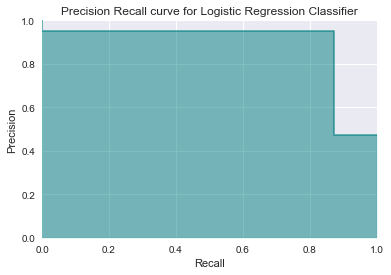

In [93]:
print('cr:', classification_report(y_test_u, y_test_lr_u))
print('Precision for unersampled Logistic Regression Classifier\n' ,metrics.precision_score(y_test_u,y_test_lr_u))
print('Recall for undersampled Logistic Regression Classifier\n' ,metrics.recall_score(y_test_u,y_test_lr_u))

precision, recall, _ = precision_recall_curve(y_test_u, y_test_lr_u)

plt.step(recall, precision, color='teal', alpha=0.6,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.5, color='teal')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall curve for Logistic Regression Classifier');

cr:              precision    recall  f1-score   support

          0       1.00      0.97      0.98     71081
          1       0.05      0.87      0.09       121

avg / total       1.00      0.97      0.98     71202



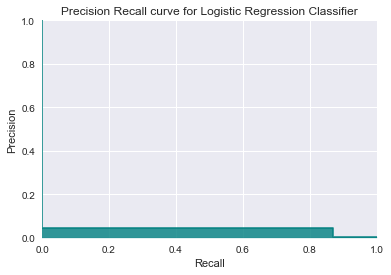

In [94]:
print('cr:', classification_report(y_test, y_test_lr_1))

precision, recall, _ = precision_recall_curve(y_test, y_test_lr_1)

plt.step(recall, precision, color='teal', alpha=0.8,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.8, color='teal')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall curve for Logistic Regression Classifier');

### Decision Tree Classifier

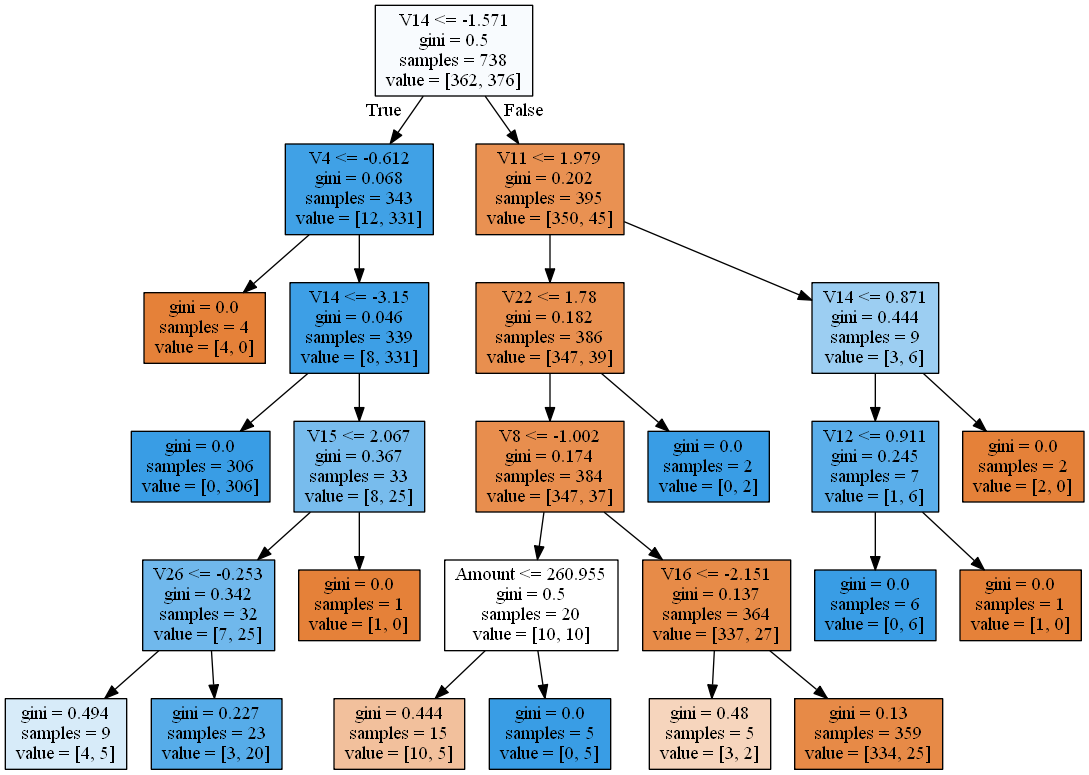

In [179]:
# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    max_features=3,
    max_depth=5,
    random_state = 1000
)

decision_tree.fit(X_train_u, y_train_u)
y_1_predictions_u = decision_tree.predict(X_test)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [180]:
y_1_predictions_1 = decision_tree.predict(X_test)

In [181]:
print("\nAccuracy on training set: {:.3f}".format(decision_tree.score(X_train_u, y_train_u)))
print("\nAccuracy on test set: {:.3f}".format(decision_tree.score(X_test_u, y_test_u)))


Accuracy on training set: 0.947

Accuracy on test set: 0.935


Confusion Matrix
 [[68323  2758]
 [   11   110]]


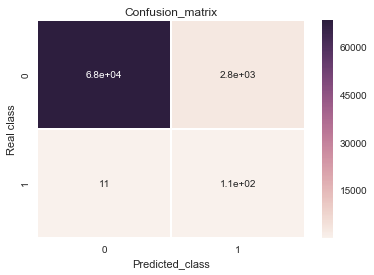

AUC for Decision tree classifier
 0.935145052188


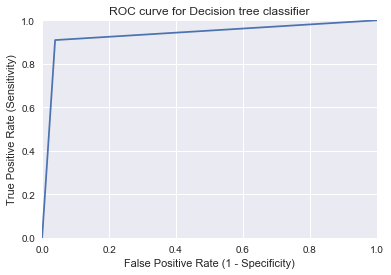

In [185]:
#confusion matrix
confusion = confusion_matrix(y_test, y_1_predictions_u)
print('Confusion Matrix\n', confusion)

sns.heatmap(confusion,annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

print('AUC for Decision tree classifier\n',auc(fpr,tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_1_predictions_u)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Decision tree classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)');

Confusion Matrix
 [[68323  2758]
 [   11   110]]


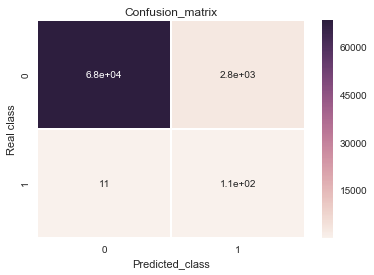

AUC for Decision tree classifier
 0.890097445575


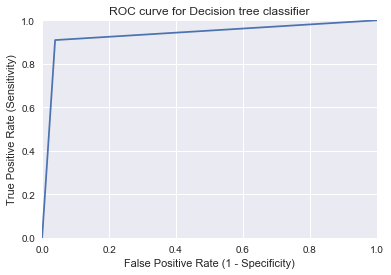

In [183]:
#confusion matrix
confusion = confusion_matrix(y_test, y_1_predictions_1)
print('Confusion Matrix\n', confusion)

sns.heatmap(confusion,annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

print('AUC for Decision tree classifier\n',auc(fpr,tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_1_predictions_1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Decision tree classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)');

cr:              precision    recall  f1-score   support

          0       0.91      0.98      0.94       130
          1       0.97      0.89      0.93       116

avg / total       0.94      0.93      0.93       246



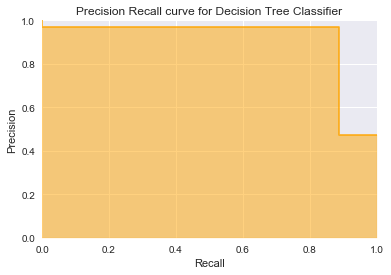

In [100]:
print('cr:', classification_report(y_test_u, y_1_predictions_u))

precision, recall, _ = precision_recall_curve(y_test_u, y_1_predictions_u)

plt.step(recall, precision, color='orange', alpha=0.8,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.5, color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall curve for Decision Tree Classifier');

cr:              precision    recall  f1-score   support

          0       1.00      0.96      0.98     71081
          1       0.04      0.91      0.07       121

avg / total       1.00      0.96      0.98     71202



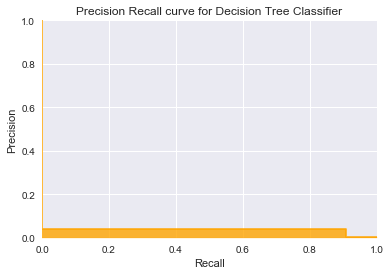

In [101]:
print('cr:', classification_report(y_test, y_1_predictions_1))

precision, recall, _ = precision_recall_curve(y_test, y_1_predictions_1)

plt.step(recall, precision, color='orange', alpha=0.8,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.8, color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall curve for Decision Tree Classifier');

### Random forest Classifier

In [102]:
#Applying Random forest classifier
rfc = ensemble.RandomForestClassifier(
    n_estimators=15,
    max_features=3,
    max_depth=5
)

rfc.fit(X_train_u, y_train_u)
y_predict_u = rfc.predict(X_test_u)

print("\nAccuracy on training set: {:.3f}".format(rfc.score(X_train_u, y_train_u)))
print("\nAccuracy on test set: {:.3f}".format(rfc.score(X_test_u, y_test_u)))


Accuracy on training set: 0.949

Accuracy on test set: 0.931


In [103]:
y_predict_r1 = rfc.predict(X_test)

Confusion Matrix
 [[127   3]
 [ 14 102]]
AUC for Random Forest  classifier
 0.935145052188


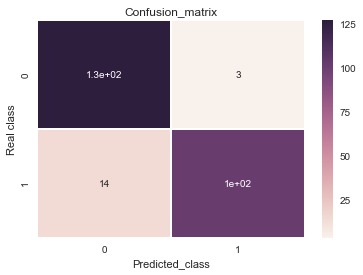

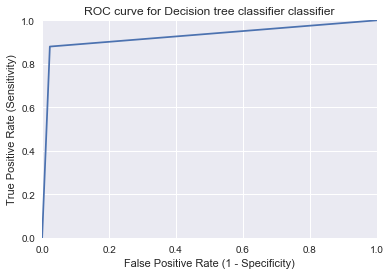

In [104]:
#confusion matrix
confusion = confusion_matrix(y_test_u, y_predict_u)
print('Confusion Matrix\n', confusion)

#Area under curve
auc(fpr,tpr)
print('AUC for Random Forest  classifier\n',auc(fpr,tpr))

sns.heatmap(confusion,annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

fpr, tpr, thresholds = metrics.roc_curve(y_test_u, y_predict_u)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Decision tree classifier classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)');

Confusion Matrix
 [[69873  1208]
 [   10   111]]
AUC for Random Forest  classifier
 0.928116710875


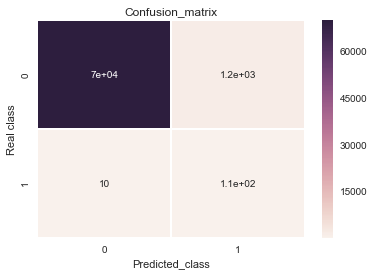

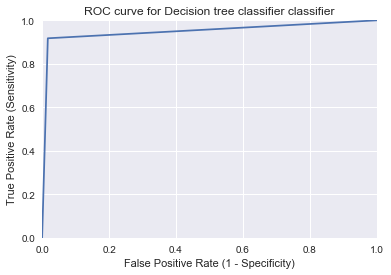

In [105]:
#confusion matrix
confusion = confusion_matrix(y_test, y_predict_r1)
print('Confusion Matrix\n', confusion)

#Area under curve
auc(fpr,tpr)
print('AUC for Random Forest  classifier\n',auc(fpr,tpr))

sns.heatmap(confusion,annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_r1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Decision tree classifier classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)');

cr:              precision    recall  f1-score   support

          0       0.90      0.98      0.94       130
          1       0.97      0.88      0.92       116

avg / total       0.93      0.93      0.93       246



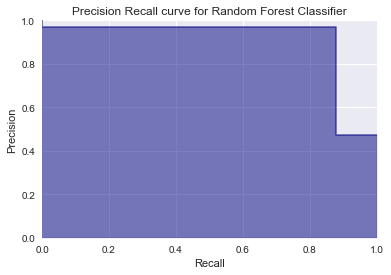

In [106]:
print('cr:', classification_report(y_test_u, y_predict_u))

precision, recall, _ = precision_recall_curve(y_test_u, y_predict_u)

plt.step(recall, precision, color='navy', alpha=0.5,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.5, color='navy')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall curve for Random Forest Classifier');

cr:              precision    recall  f1-score   support

          0       1.00      0.98      0.99     71081
          1       0.08      0.92      0.15       121

avg / total       1.00      0.98      0.99     71202



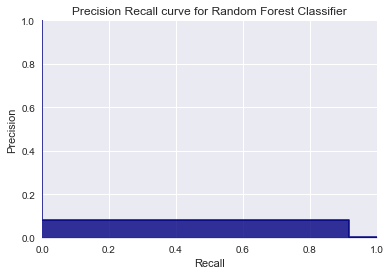

In [107]:
print('cr:', classification_report(y_test, y_predict_r1))

precision, recall, _ = precision_recall_curve(y_test, y_predict_r1)

plt.step(recall, precision, color='navy', alpha=0.8,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.8, color='navy')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall curve for Random Forest Classifier');

### SMOTE

Now we will try oversampling by generating synthetic data.Let us see what results we get


In [110]:
#lets start with importing libraries
from imblearn.over_sampling import SMOTE
# Separating dependent and independant features
y = creditcard_df['Class']
X = creditcard_df.drop(['Class'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state=5)

from imblearn.over_sampling import SMOTE
sm = SMOTE('auto', random_state=42)

X_OverSampled, y_OverSampled = sm.fit_sample(X_train, y_train)

# compare the before and after
from collections import Counter
print('Original Dataset shape: {}'.format(Counter(y_train)))
print('Oversampled Dataset shape: {}'.format(Counter(y_OverSampled)))

Original Dataset shape: Counter({0: 213234, 1: 371})
Oversampled Dataset shape: Counter({0: 213234, 1: 213234})


In [114]:
print("Oversampled independent variables:",X_OverSampled.shape)
print("Oversampled dependent variables:",y_OverSampled.shape)

Oversampled independent variables: (426468, 30)
Oversampled dependent variables: (426468,)


Let us use this data in different models as we did previously

### SVM

In [116]:
# start a timer
start = time.time()

# Create the classifier model
svm = LinearSVC()

#fit the model
svm.fit(X_OverSampled, y_OverSampled)

#Stop the timer
end = time.time()

print("Linear SVC", end - start, svm.score(X_test,y_test))
y_test_svsm = svm.predict(X_test)

# now evaluate the Single SVC model
y_score_svsm = svm.decision_function(X_test)

# Find the average precision score
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score_svsm)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score_svsm, pos_label=1)

print('AUC for Single Linear SVC\n', auc(fpr,tpr))

Linear SVC 291.19296169281006 0.989045251538
Average precision-recall score: 0.43
AUC for Single Linear SVC
 0.942860321963


In [117]:
print('cr:', classification_report(y_test,y_test_svsm))
print('Precision for oversampled SVM Classifier\n' ,metrics.precision_score(y_test,y_test_svsm))
print('Recall for oversampled SVM Classifier\n' ,metrics.recall_score(y_test,y_test_svsm))

cr:              precision    recall  f1-score   support

          0       1.00      0.99      0.99     71081
          1       0.11      0.80      0.20       121

avg / total       1.00      0.99      0.99     71202

Precision for oversampled SVM Classifier
 0.113716295428
Recall for oversampled SVM Classifier
 0.801652892562


Confusion Matrix
 [[70325   756]
 [   24    97]]


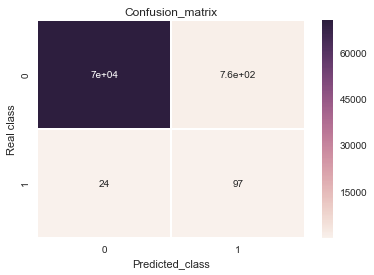

AUC for Single Linear SVC
 0.942860321963


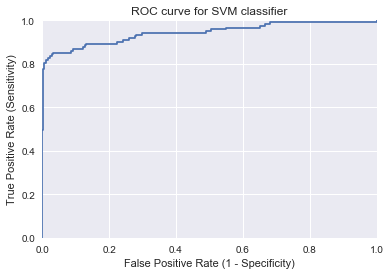

In [118]:
#Confusion Matrix
confusion = confusion_matrix(y_test, y_test_svsm)

print('Confusion Matrix\n', confusion)

sns.heatmap(confusion,annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show();

#Area under curve
auc(fpr,tpr)
print('AUC for Single Linear SVC\n', auc(fpr,tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score_svsm, pos_label=1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for SVM classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)');

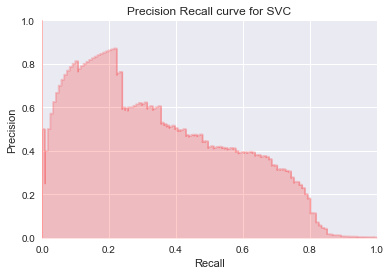

In [119]:
precision, recall, _ = precision_recall_curve(y_test, y_score_svsm)


plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='r')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall curve for SVC');

### Bagging Classifier

In [120]:

n_estimators = 10
start = time.time()
clf = BaggingClassifier(LinearSVC(class_weight='balanced'), max_samples=1.0 / n_estimators, n_estimators=n_estimators)
clf.fit(X_OverSampled, y_OverSampled)
end = time.time()
print("Bagging SVC", end - start, clf.score(X,y))

# Evaluate the Ensemble model
y_score_bag_sv = clf.decision_function(X_test)
y_test_bag_sv = clf.predict(X_test)
# Find the average precision score
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, pos_label=1)

print('AUC for Ensemble model\n', auc(fpr,tpr))


Bagging SVC 3077.353955745697 0.985133792358
Average precision-recall score: 0.12
AUC for Ensemble model
 0.670637304595


cr:              precision    recall  f1-score   support

          0       1.00      0.99      0.99     71081
          1       0.09      0.83      0.16       121

avg / total       1.00      0.99      0.99     71202

Precision for oversampled SVM Classifier
 0.0911577028259
Recall for oversampled SVM Classifier
 0.826446280992
Confusion Matrix
 [[70084   997]
 [   21   100]]


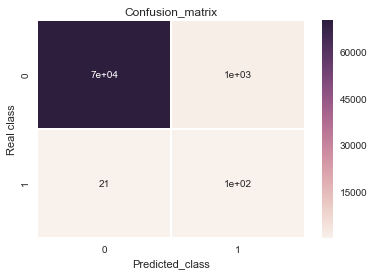

AUC for Single Linear SVC
 0.670637304595


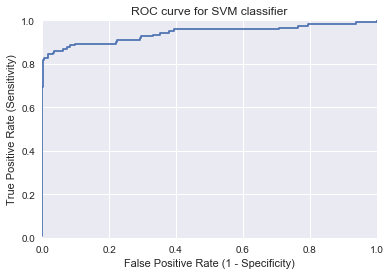

In [122]:
print('cr:', classification_report(y_test,y_test_bag_sv))
print('Precision for oversampled SVM Classifier\n' ,metrics.precision_score(y_test,y_test_bag_sv))
print('Recall for oversampled SVM Classifier\n' ,metrics.recall_score(y_test,y_test_bag_sv))

#Confusion Matrix
confusion = confusion_matrix(y_test, y_test_bag_sv)

print('Confusion Matrix\n', confusion)

sns.heatmap(confusion,annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show();

#Area under curve
auc(fpr,tpr)
print('AUC for Single Linear SVC\n', auc(fpr,tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score_bag_sv, pos_label=1)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for SVM classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)');

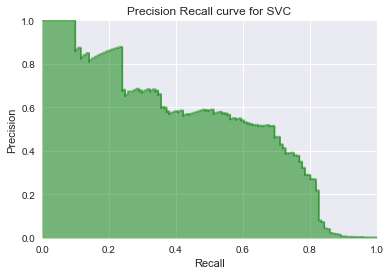

In [123]:
precision, recall, _ = precision_recall_curve(y_test, y_score_bag_sv)


plt.step(recall, precision, color='g', alpha=0.5,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.5, color='g')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall curve for SVC');

### Logistic Regression


Accuracy on training set:
0.966236622677

Accuracy on test set:
0.984270104772
cr:              precision    recall  f1-score   support

          0       1.00      0.98      0.99     71081
          1       0.09      0.91      0.16       121

avg / total       1.00      0.98      0.99     71202

Precision for Logistic Regression Classifier
 0.090237899918
Recall for logistic Regression Classifier
 0.909090909091


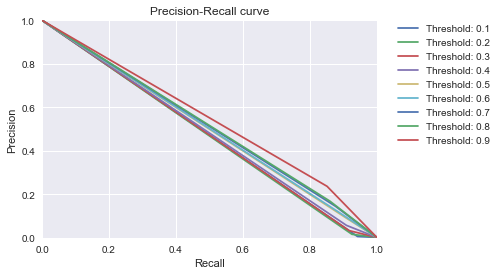

In [128]:
#applying logistic regression
lr = LogisticRegression(penalty='l2', C=0.001)
fit_train = lr.fit(X_OverSampled, y_OverSampled)

y_test_lr_sm = lr.predict(X_test)
y_score_lr_sm = lr.decision_function(X_test)
#Accuracy score
from sklearn.metrics import accuracy_score
print("\nAccuracy on training set:") 
print(lr.score(X_OverSampled, y_OverSampled))
print("\nAccuracy on test set:")
print(lr.score(X_test, y_test))

y_pred_o_proba_sv=lr.predict_proba(X_test)[:,1]

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in thresholds:
    y_test_pred_prob = y_pred_o_proba_sv > i
    precision, recall, thresholds= precision_recall_curve(y_test,y_test_pred_prob)
    plt.plot(recall, precision,label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title('Precision-Recall curve')    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

print('cr:', classification_report(y_test,y_test_lr_sm))
print('Precision for Logistic Regression Classifier\n' ,metrics.precision_score(y_test, y_test_lr_sm))
print('Recall for logistic Regression Classifier\n' ,metrics.recall_score(y_test, y_test_lr_sm))

Confusion Matrix
 [[69972  1109]
 [   11   110]]


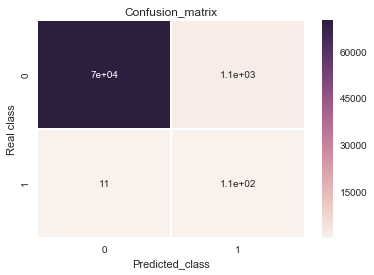

AUC for Logistic regression
 0.882026918191


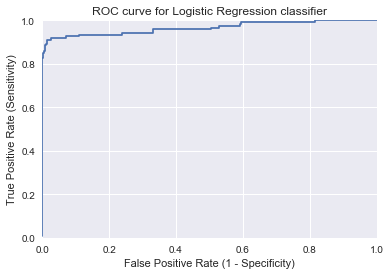

In [129]:
#Confusion Matrix
confusion = confusion_matrix(y_test, y_test_lr_sm)

print('Confusion Matrix\n', confusion)

sns.heatmap(confusion,annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show();

#Area under curve
auc(fpr,tpr)
print('AUC for Logistic regression\n',auc(fpr,tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score_lr_sm)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Logistic Regression classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)');

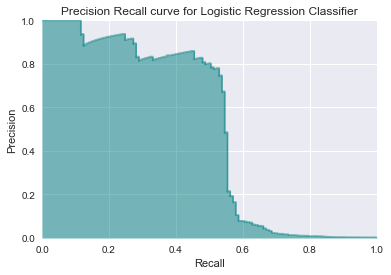

In [130]:
precision, recall, _ = precision_recall_curve(y_test, y_score_lr)


plt.step(recall, precision, color='teal', alpha=0.5,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.5, color='teal')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall curve for Logistic Regression Classifier');

### Decision Tree

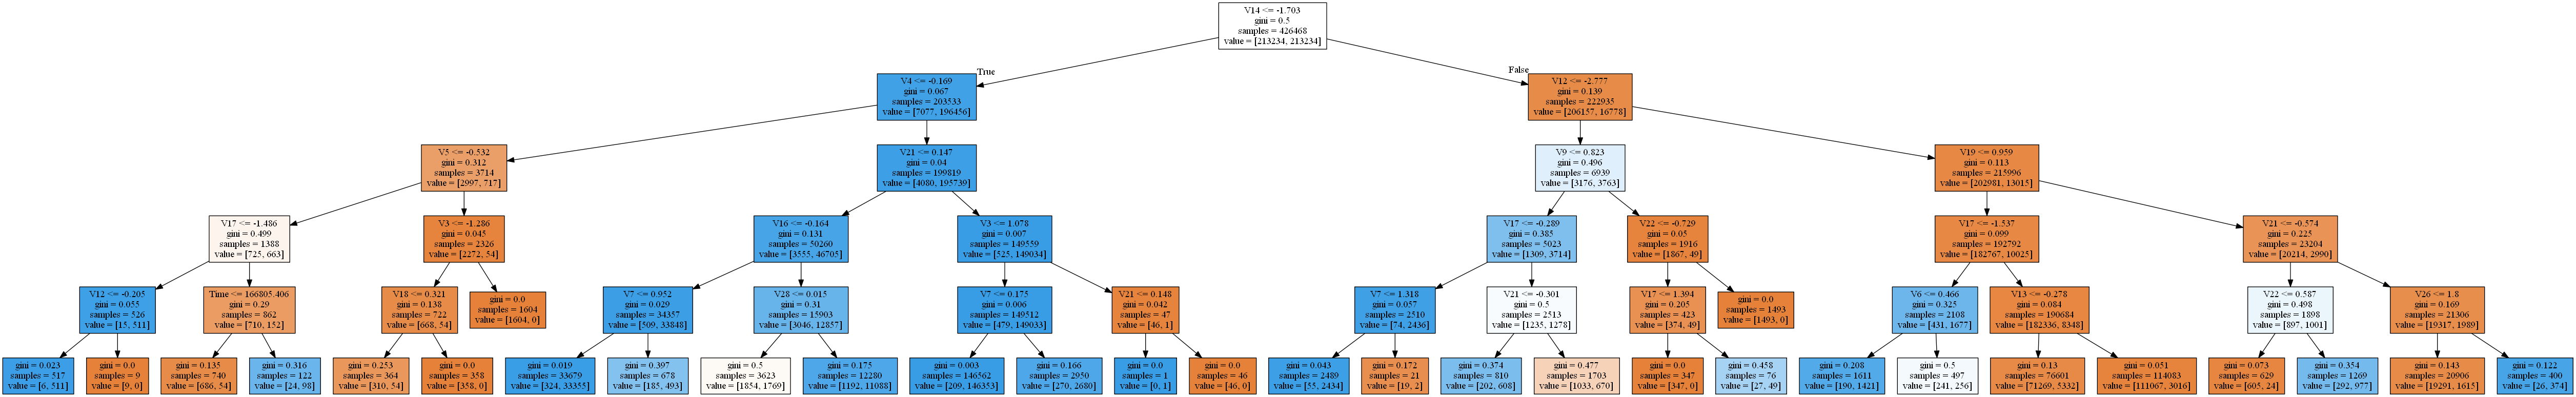

In [131]:
# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    max_features=3,
    max_depth=5,
    random_state = 1000
)

decision_tree.fit(X_OverSampled, y_OverSampled)
y_1_predictions_sm = decision_tree.predict(X_test)

# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [139]:
print("\nAccuracy on training set: {:.3f}".format(decision_tree.score(X_OverSampled, y_OverSampled)))
print("\nAccuracy on test set: {:.3f}".format(decision_tree.score(X_test, y_test)))


Accuracy on training set: 0.963

Accuracy on test set: 0.985


Confusion Matrix
 [[70000  1081]
 [   16   105]]


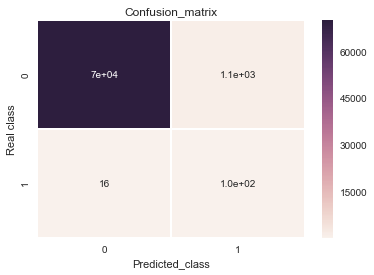

AUC for Decision tree classifier
 0.790752977542


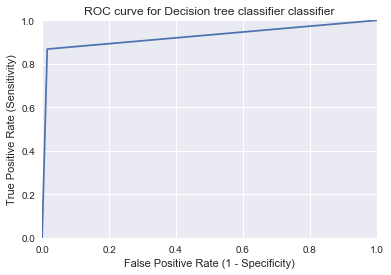

In [140]:
#confusion matrix
confusion = confusion_matrix(y_test, y_1_predictions_sm)
print('Confusion Matrix\n', confusion)

sns.heatmap(confusion,annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

print('AUC for Decision tree classifier\n',auc(fpr,tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_1_predictions_sm)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Decision tree classifier classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)');

cr:              precision    recall  f1-score   support

          0       1.00      0.98      0.99     71081
          1       0.09      0.87      0.16       121

avg / total       1.00      0.98      0.99     71202

Precision for Decision Tree Classifier
 0.0885328836425
Recall for Decision Tree Classifier
 0.867768595041


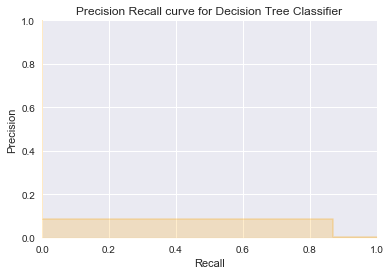

In [141]:
print('cr:', classification_report(y_test, y_1_predictions_sm))
print('Precision for Decision Tree Classifier\n' ,metrics.precision_score(y_test, y_1_predictions_sm))
print('Recall for Decision Tree Classifier\n' ,metrics.recall_score(y_test, y_1_predictions_sm))
precision, recall, _ = precision_recall_curve(y_test, y_1_predictions_sm)

plt.step(recall, precision, color='orange', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall curve for Decision Tree Classifier');

### RandomForest Classifier

In [142]:
#Applying Random forest classifier
rfc = ensemble.RandomForestClassifier(
    n_estimators=15,
    max_features=3,
    max_depth=5
)

rfc.fit(X_OverSampled, y_OverSampled)
y_predict_rfsm = rfc.predict(X_test)

print("\nAccuracy on training set: {:.3f}".format(rfc.score(X_OverSampled, y_OverSampled)))
print("\nAccuracy on test set: {:.3f}".format(rfc.score(X_test, y_test)))


Accuracy on training set: 0.964

Accuracy on test set: 0.996


Confusion Matrix
 [[70842   239]
 [   15   106]]


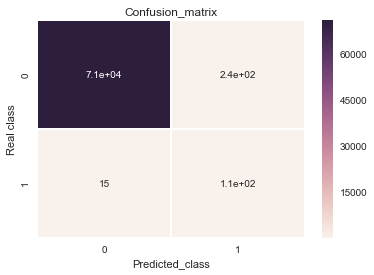

AUC for Decision tree classifier
 0.926280296451


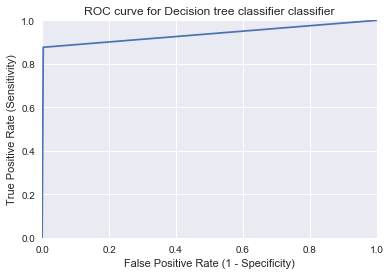

In [143]:
#confusion matrix
confusion = confusion_matrix(y_test, y_predict_rfsm)
print('Confusion Matrix\n', confusion)

sns.heatmap(confusion,annot=True,linewidths=0.5)
plt.title("Confusion_matrix")
plt.xlabel("Predicted_class")
plt.ylabel("Real class")
plt.show()

print('AUC for Decision tree classifier\n',auc(fpr,tpr))
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict_rfsm)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for Decision tree classifier classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)');

cr:              precision    recall  f1-score   support

          0       1.00      1.00      1.00     71081
          1       0.31      0.88      0.45       121

avg / total       1.00      1.00      1.00     71202

Precision for Decision Tree Classifier
 0.307246376812
Recall for Decision Tree Classifier
 0.876033057851


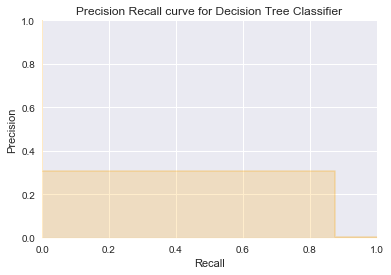

In [144]:
print('cr:', classification_report(y_test, y_predict_rfsm))
print('Precision for Decision Tree Classifier\n' ,metrics.precision_score(y_test, y_predict_rfsm))
print('Recall for Decision Tree Classifier\n' ,metrics.recall_score(y_test, y_predict_rfsm))
precision, recall, _ = precision_recall_curve(y_test,y_predict_rfsm)

plt.step(recall, precision, color='orange', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='orange')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.title('Precision Recall curve for Decision Tree Classifier');

In [149]:
#summing up results of all the models and forming a dataframe
results_sm = [{'Model':'SVM','F1 Score': 0.2,'AUC':0.942,'Precision':0.113,'Recall':0.801},
            {'Model':'Bagging','F1 Score': 0.16,'AUC':0.67,'Precision':0.09,'Recall':0.83},
            {'Model':'Logistic Regression','F1 Score': 0.16,'AUC':0.966,'Precision':0.09,'Recall':0.91},
            {'Model':'Decision Tree Classifier','F1 Score': 0.16,'AUC':0.966,'Precision':0.09,'Recall':0.87},
            {'Model':'Random Forest Classifier','F1 Score': 0.5,'AUC':0.926,'Precision':0.31,'Recall':0.88},
            ]
results_sm_df = pd.DataFrame(results_sm)
results_sm_df.head()

f,(ax1, ax2,ax3,ax4) = plt.subplots(4,1,figsize = (8,8), sharex = True)
sns.barplot(x = "F1 Score", y= "Model", data=results_sm_df , ax = ax1)
sns.barplot(x = "AUC", y= "Model", data=results_sm_df, ax = ax2)
sns.barplot(x = "Precision", y= "Model", data=results_sm_df , ax = ax3)
sns.barplot(x = "Recall", y= "Model", data=results_sm_df , ax = ax4);

,AUC,F1 Score,Model,Precision,Recall
0,0.942,0.20,SVM,0.113,0.801
1,0.670,0.16,Bagging,0.090,0.830
2,0.966,0.16,Logistic Regression,0.090,0.910
3,0.966,0.16,Decision Tree Classifier,0.090,0.870
4,0.926,0.50,Random Forest Classifier,0.310,0.880


### Comparitive plot of different models and their evaluation with different data treatment

### SMOTE

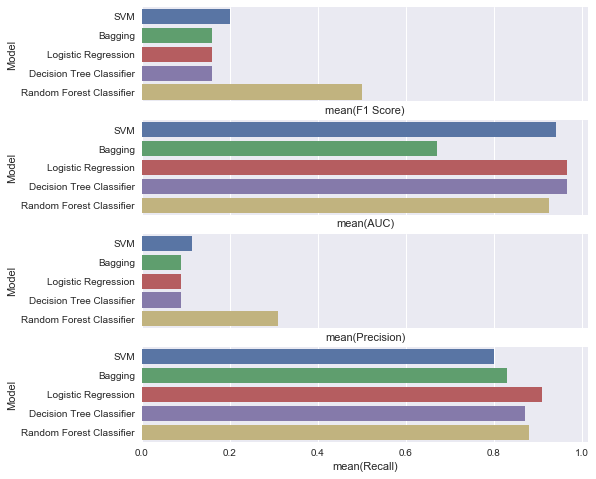

In [169]:
f,(ax1, ax2,ax3,ax4) = plt.subplots(4,1,figsize = (8,8), sharex = True)
sns.barplot(x = "F1 Score", y= "Model", data=results_sm_df , ax = ax1)
sns.barplot(x = "AUC", y= "Model", data=results_sm_df, ax = ax2)
sns.barplot(x = "Precision", y= "Model", data=results_sm_df , ax = ax3)
sns.barplot(x = "Recall", y= "Model", data=results_sm_df , ax = ax4);

### Undersampled Data

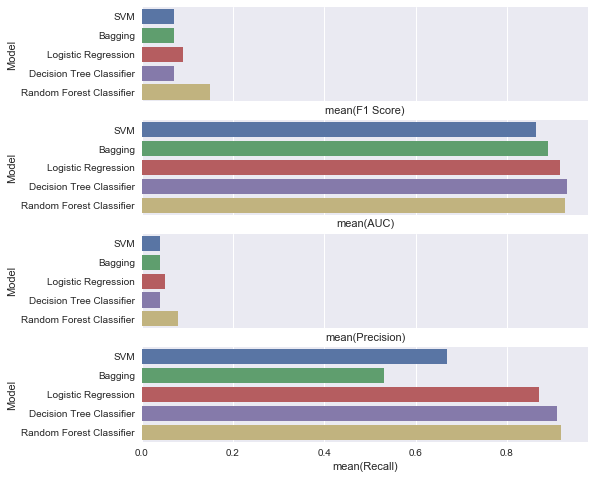

In [186]:
#summing up results of all the models and forming a dataframe
results_u = [{'Model':'SVM','F1 Score': 0.07,'AUC':0.865,'Precision':0.04,'Recall':0.67},
            {'Model':'Bagging','F1 Score': 0.07,'AUC':0.89,'Precision':0.04,'Recall':0.53},
            {'Model':'Logistic Regression','F1 Score': 0.09,'AUC':0.916,'Precision':0.05,'Recall':0.87},
            {'Model':'Decision Tree Classifier','F1 Score': 0.07,'AUC':0.932,'Precision':0.04,'Recall':0.91},
            {'Model':'Random Forest Classifier','F1 Score': 0.15,'AUC':0.928,'Precision':0.08,'Recall':0.92},
            ]
results_u_df = pd.DataFrame(results_u)
f,(ax1, ax2,ax3,ax4) = plt.subplots(4,1,figsize = (8,8), sharex = True)
sns.barplot(x = "F1 Score", y= "Model", data=results_u_df , ax = ax1)
sns.barplot(x = "AUC", y= "Model", data=results_u_df, ax = ax2)
sns.barplot(x = "Precision", y= "Model", data=results_u_df , ax = ax3)
sns.barplot(x = "Recall", y= "Model", data=results_u_df , ax = ax4);

### Oversampled Data

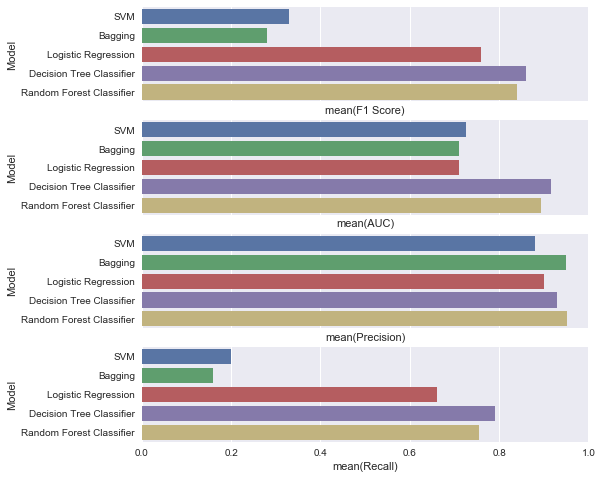

In [167]:
#summing up results of all the models and forming a dataframe
results_o = [{'Model':'SVM','F1 Score': 0.33,'AUC':0.725,'Precision':0.88,'Recall':0.2},
            {'Model':'Bagging','F1 Score': 0.28,'AUC':0.711,'Precision':0.95,'Recall':0.16},
            {'Model':'Logistic Regression','F1 Score': 0.76,'AUC':0.711,'Precision':0.9,'Recall':0.66},
            {'Model':'Decision Tree Classifier','F1 Score': 0.86,'AUC':0.917,'Precision':0.93,'Recall':0.79},
            {'Model':'Random Forest Classifier','F1 Score': 0.84,'AUC':0.894,'Precision':0.952,'Recall':0.754},
            ]
results_o_df = pd.DataFrame(results_o)

results_o_df.head()

f,(ax1, ax2,ax3,ax4) = plt.subplots(4,1,figsize = (8,8), sharex = True)
sns.barplot(x = "F1 Score", y= "Model", data=results_o_df , ax = ax1)
sns.barplot(x = "AUC", y= "Model", data=results_o_df, ax = ax2)
sns.barplot(x = "Precision", y= "Model", data=results_o_df , ax = ax3)
sns.barplot(x = "Recall", y= "Model", data=results_o_df , ax = ax4);

### Imbalanced data

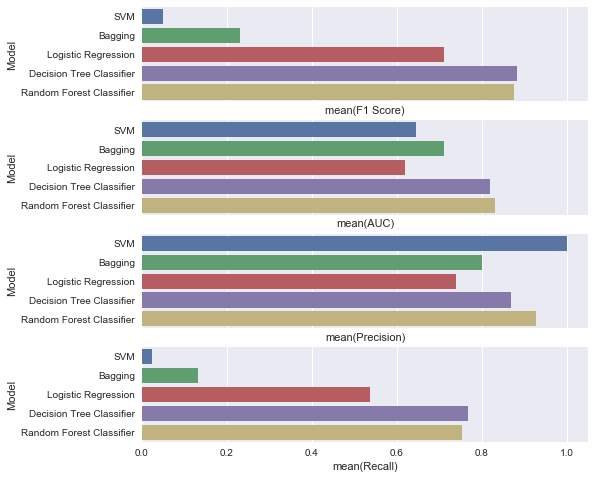

In [45]:
f,(ax1, ax2,ax3,ax4) = plt.subplots(4,1,figsize = (8,8), sharex = True)
sns.barplot(x = "F1 Score", y= "Model", data=results1_df , ax = ax1)
sns.barplot(x = "AUC", y= "Model", data=results1_df, ax = ax2)
sns.barplot(x = "Precision", y= "Model", data=results1_df , ax = ax3)
sns.barplot(x = "Recall", y= "Model", data=results1_df , ax = ax4);

In [7]:
result = [{'Model':'SVM','Approach':'Imbalanced Data','F1 Score': 0.05,'AUC':0.644,'Precision':1.00,'Recall':0.024},
           {'Model':'Bagging','Approach':'Imbalanced Data','F1 Score': 0.23,'AUC':0.711,'Precision':0.8,'Recall':0.132},
           {'Model':'Logistic Regression','Approach':'Imbalanced Data','F1 Score': 0.711,'AUC':0.62,'Precision':0.738,'Recall':0.537},
           {'Model':'Decision Tree Classifier','Approach':'Imbalanced Data','F1 Score': 0.882,'AUC':0.82,'Precision':0.869,'Recall':0.768},
           {'Model':'Random Forest Classifier','Approach':'Imbalanced Data','F1 Score': 0.876,'AUC':0.83,'Precision':0.928,'Recall':0.752},
           {'Model':'SVM','Approach':'Oversampled Data','F1 Score': 0.33,'AUC':0.725,'Precision':0.88,'Recall':0.2},
           {'Model':'Bagging','Approach':'Oversampled Data','F1 Score': 0.28,'AUC':0.711,'Precision':0.95,'Recall':0.16},
           {'Model':'Logistic Regression','Approach':'Oversampled Data','F1 Score': 0.76,'AUC':0.711,'Precision':0.9,'Recall':0.66},
           {'Model':'Decision Tree Classifier','Approach':'Oversampled Data','F1 Score': 0.86,'AUC':0.917,'Precision':0.93,'Recall':0.79},
           {'Model':'Random Forest Classifier','Approach':'Oversampled Data','F1 Score': 0.84,'AUC':0.894,'Precision':0.952,'Recall':0.754},
           {'Model':'SVM','Approach':'Undersampled Data','F1 Score': 0.07,'AUC':0.865,'Precision':0.04,'Recall':0.67},
           {'Model':'Bagging','Approach':'Undersampled Data','F1 Score': 0.07,'AUC':0.89,'Precision':0.04,'Recall':0.53},
           {'Model':'Logistic Regression','Approach':'Undersampled Data','F1 Score': 0.09,'AUC':0.916,'Precision':0.05,'Recall':0.87},
           {'Model':'Decision Tree Classifier','Approach':'Undersampled Data','F1 Score': 0.07,'AUC':0.932,'Precision':0.04,'Recall':0.91},
           {'Model':'Random Forest Classifier','Approach':'Undersampled Data','F1 Score': 0.15,'AUC':0.928,'Precision':0.08,'Recall':0.92},
           {'Model':'SVM','Approach':'SMOTE','F1 Score': 0.2,'AUC':0.942,'Precision':0.113,'Recall':0.801},
           {'Model':'Bagging','Approach':'SMOTE','F1 Score': 0.16,'AUC':0.67,'Precision':0.09,'Recall':0.83},
           {'Model':'Logistic Regression','Approach':'SMOTE','F1 Score': 0.16,'AUC':0.966,'Precision':0.09,'Recall':0.91},
           {'Model':'Decision Tree Classifier','Approach':'SMOTE','F1 Score': 0.16,'AUC':0.966,'Precision':0.09,'Recall':0.87},
           {'Model':'Random Forest Classifier','Approach':'SMOTE','F1 Score': 0.5,'AUC':0.926,'Precision':0.31,'Recall':0.88}
           ]
results = pd.DataFrame(result)
results.head()

,AUC,Approach,F1 Score,Model,Precision,Recall
0,0.644,Imbalanced Data,0.050,SVM,1.000,0.024
1,0.711,Imbalanced Data,0.230,Bagging,0.800,0.132
2,0.620,Imbalanced Data,0.711,Logistic Regression,0.738,0.537
3,0.820,Imbalanced Data,0.882,Decision Tree Classifier,0.869,0.768
4,0.830,Imbalanced Data,0.876,Random Forest Classifier,0.928,0.752


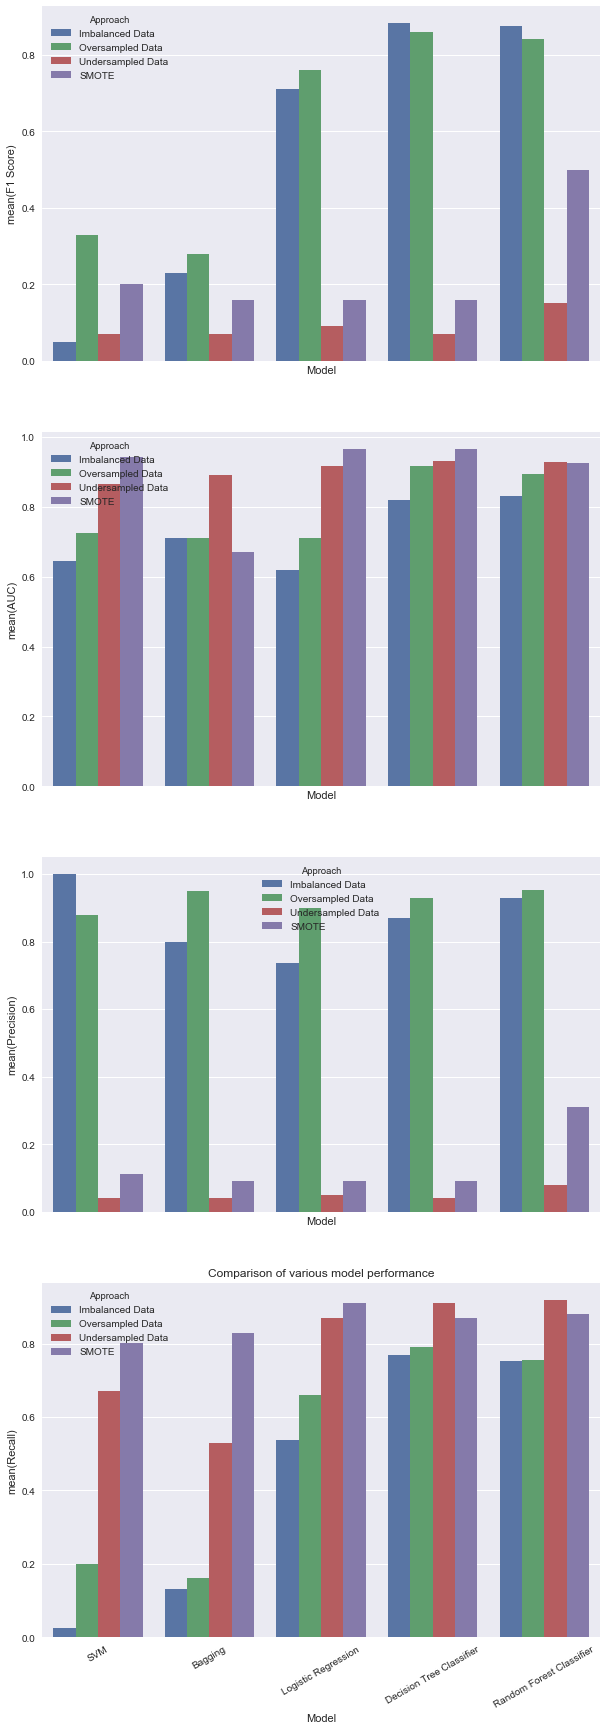

In [10]:
f,(ax1, ax2,ax3,ax4) = plt.subplots(4,1,figsize = (10,30), sharex = True)
sns.axes_style()
plt.title("Comparison of various model performance")
plt.xticks(rotation=30)
sns.barplot(x = "Model", y= "F1 Score", hue="Approach", data=results , ax = ax1)
sns.barplot(x = "Model", y= "AUC", hue="Approach", data=results, ax = ax2)
sns.barplot(x = "Model", y= "Precision", hue="Approach", data=results , ax = ax3)
sns.barplot(x = "Model", y= "Recall", hue="Approach", data=results , ax = ax4);

From the above plot we can see see that SVM performs well when we consider AUC to evaluate our model.SMOTE approach gives us highest AUC in Logistic regression and decision tree model.In case of F1 score and specificity Imbalanced data approach gives us good results but we reduce the sensitivity of our model in that context.If we increase sensitivity we lose specificity.

In such scenario depending on AUC to evaluate our models seems to be best approach.

### Referances:

    http://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation
    https://classeval.wordpress.com/introduction/introduction-to-the-precision-recall-plot/
    http://www.jair.org/media/953/live-953-2037-jair.pdf
    https://classeval.wordpress.com/simulation-analysis/roc-and-precision-recall-with-imbalanced-datasets/